The data download/processing portion referenced: 
https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/1_data.ipynb
https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb#scrollTo=J2FYrPgOKh6t
https://github.com/googlecreativelab/quickdraw-dataset/issues/19#issuecomment-402247262
https://raw.githubusercontent.com/tensorflow/models/r1.13.0/tutorials/rnn/quickdraw/train_model.py
https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/recurrent_quickdraw.md

# Install and Load libraries

In [ ]:
# installation needed (cairocffi is not needed right now when loading data)
# ! pip install cairocffi
# ! pip install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
from google.colab import files, drive
drive.mount('/content/drive/', force_remount=True)
#! cp drive/MyDrive/TTIC31220-Winter21/hw3/*.py ./
#! cp drive/MyDrive/TTIC31220-Winter21/hw2/*.py ./
#! cp drive/MyDrive/TTIC31220-Winter21/hw1.zip ./hw1.zip
#! unzip hw1.zip 
! cp drive/MyDrive/unsupervised_final_project/utils/*.py ./

Mounted at /content/drive/


In [ ]:
import os
import glob
import numpy as np
import urllib.request
from matplotlib import pyplot as plt
from utils import resize
from plot import plot_images
from sklearn.decomposition import PCA, KernelPCA
from scipy import ndimage, misc
import json
import tensorflow as tf
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import math
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import requests

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy

# Helper Functions

In [ ]:
def download(classes):
    """
    Download Numpy bitmap files from Google Cloud Storage
    """
    
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:
      print(c)
      cls_url = c.replace('_', '%20')
      cls_url = c.replace(' ', '%20')
      path = base+cls_url+'.npy'
      print(path)
      urllib.request.urlretrieve(path, data_path+c+'.npy')


def download_vectors(classes):
    """
    Download Vector information (ndjson format) from Google Cloud Storage
    """

    base = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/'
    for c in classes:
      print(c)
      cls_url = c.replace('_', '%20')
      cls_url = c.replace(' ', '%20')
      path = base+cls_url+'.ndjson'
      print(path)
      urllib.request.urlretrieve(path, data_path+c+'.ndjson')


def split_data(data): 
    """
    Split data to train, dev, devtest, test
    """
    n = len(data)
    split_1 = int(n * 0.3)
    split_2 = int(n * 0.5)
    split_3 = int(n * 0.7)

    return data[:split_1], data[split_1:split_2], data[split_2:split_3], data[split_3:]


def convert(line):
    """
    Converts a single JSON line and converts 'drawing' to list of np.array.
    """
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d


def loaditer(name, unrecognized=False):
    """
    Returns iterable of drawings in specified file.

    Args:
        name: Name of the downloaded object (e.g. "elephant").
        unrecognized: Whether to include drawings that were not recognized
            by Google AI (i.e. the hard ones).
    """

    for line in tf.io.gfile.GFile('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)  
        if d['recognized'] or unrecognized:
            yield d['drawing']

def format_strokes(strokes):
    """
    Parse an ndjson line and return ink (as np array)
    """
    
    #sample = json.loads(ndjson_line)
    # class_name = sample["word"]
    inkarray = strokes
    stroke_lengths = [len(stroke[0]) for stroke in inkarray]
    total_points = sum(stroke_lengths)
    np_ink = np.zeros((total_points, 3), dtype=np.float32)
    current_t = 0
    for stroke in inkarray:
      for i in [0, 1]:
        np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
      current_t += len(stroke[0])
      np_ink[current_t - 1, 2] = 1  # stroke_end
    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(np_ink[:, 0:2], axis=0)
    upper = np.max(np_ink[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
    # 2. Compute deltas.
    np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
    np_ink = np_ink[1:, :]
    return np_ink #, class_name


def load_data(names, class_size=15000, unrecognized=True):
    """
    Load data with pixel and stroke information

    Args:
        names: list of names of downloaded objects (e.g. "elephant").
        unrecognized: Whether to include drawings that were not recognized
            by Google AI (i.e. the hard ones). (Default to true to match pixel data)
    """

    files = glob.glob(os.path.join(data_path, "*.npy"))
    x_pixel = np.empty([0, 784])
    x_vector = []
    x_ink = []
    y = np.empty([0], dtype=int)
    class_names = []

    for idx, name in enumerate(names): 
        pixel_data = np.load('/content/drive/My Drive/unsupervised_final_project/data/{}.npy'.format(name)) # load pixel file
        vector_data = list(loaditer(name, unrecognized=unrecognized)) # load vector data
        pixel_data = pixel_data[:class_size, :]
        vector_data = vector_data[:class_size]
        labels = np.full(pixel_data.shape[0], idx)

        x_pixel = np.concatenate((x_pixel, pixel_data), axis=0)
        x_vector.extend(vector_data)
        ink_data = [format_strokes(vector) for vector in vector_data]
        x_ink.extend(ink_data)
        y = np.append(y, labels)

        # class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(name)

    data = None
    labels = None

    #randomize the dataset 
    np.random.seed(1000)
    permutation = np.random.permutation(y.shape[0])
    x_pixel = x_pixel[permutation, :]
    x_vector = [x_vector[i] for i in permutation]
    x_ink = [x_ink[i] for i in permutation]
    y = y[permutation]

    x_pixel_data = split_data(x_pixel)
    x_vector_data = split_data(x_vector)
    x_ink_data = split_data(x_ink)
    y_data = split_data(y)

    return x_pixel_data, x_vector_data, x_ink_data, y_data

def sample_labeled_data(x_pixel, x_ink, y, size, test=False):
    """
    test=True if generating the labeled test set
    """
    labeled_data = {}

    for i in range(10, 51, 5): 
        idx = np.where(y < i)[0]
        split = int(0.7 * size)

        if test: 
            x_pixel_test = x_pixel[idx][:size]
            x_ink_test = [x_ink[i] for i in idx[:size]]
            y_test = y[idx][:size]
            labeled_data[i] = (x_pixel_test, x_ink_test, y_test)
        else: 
            train_idx = idx[:split]
            dev_idx = idx[split: size]
            x_pixel_train = x_pixel[train_idx]
            x_pixel_dev = x_pixel[dev_idx]
            x_ink_train = [x_ink[i] for i in train_idx]
            x_ink_dev = [x_ink[i] for i in dev_idx]
            y_train = y[train_idx]
            y_dev = y[dev_idx]

            labeled_data[i] = (x_pixel_train, x_ink_train, y_train, x_pixel_dev, x_ink_dev, y_dev)
    return labeled_data


def visualize_ink_image(ink_array): 
    stroke = np.transpose(ink_array)
    xy = stroke[:2, :].cumsum(axis=1)
    plt.plot(xy[0,:], -xy[1,:])
    pxy = xy[:, stroke[2] != 0]
    # Indicate the new stroke with a red circle.
    plt.plot(pxy[0], -pxy[1], 'ro')
    # plt.xlim([-0.8,0.8])
    # plt.ylim([-0.8,0.8])
    plt.show()

In [ ]:
# t-SNE visualization code from hw2
## TSNE
EPS=1.0e-12
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)


class LowEmb(nn.Module):
    """
        Computing t-SNE low-dim embedding
    """
    def __init__(self, n, d):
        """
          Input
            n: int, number of data points
            d: int, target dimensionality 
        """
        super(LowEmb, self).__init__()
        self.Y = nn.Embedding(n, d)


    def forward(self, P, dof, metric):
        """
          Compute similarity between distribution in low and high 
            dimensional space
        ------
          Input
            P: 2d-array of shape (n, n), distribution in high-dim space
            dof: float, degree of freedom of Student-t distribution
            metric: string, type of divergence
        """

        # Compute low-dim distribution Q
        Y = self.Y.weight
        Y2 = torch.sum(Y.pow(2), dim=1, keepdim=True)
        D = Y2 - 2 * Y.matmul(Y.t()) + Y2.t()
        Q = (1 - torch.eye(Y.shape[0]).type_as(D)) * (1 + D/dof).pow(
            -(dof + 1)/2.0)
        Q = (Q/Q.sum()).clamp_(min=EPS)

        # Compute discrepency between P and Q
        if metric == 'KL':
            C = torch.sum(P*torch.log(P/Q))
        else:
            C = torch.sum(Q*torch.log(Q/P))
        return C


class TSNE(object):
    """
    Main Module of t-SNE
    Parameters:
    ------ 
    n_components: int, dimension to reduce to (default: 2)
    perplexity: float, perplexity of data in high-dimensional space 
        (default: 30)
    n_iters: int, number of iterations for optimization (default: 1000)
    lr: float, learning rate (default: 100)
    optimizer: string, type of optimizer
        "Jacob" | "Adam" | "SGD" | "RMSprop" | "Adagrad" | "Adadelta" 
        (default: "Jacob")
    cuda: bool, whether to use GPU if available (default: True)
    dof: float, degree of freedom of Student-t distribution (default: 1.0)
    metric: string, type of divergence between high and low dimensional space 
        (default: "KL")
    early_exaggeration: float, constant to multiply to high dimensional 
        probability, used in early stages of optimization to exaggerate the 
        divergence between low and high dimensional space. See the original 
        t-SNE paper for details (default: 4)
    early_iters: int, number of iterations to do early exaggeration 
        (default: 100)
    log_interval: int, iteration interval to show error (default: 100)
    init: string, initialization of low-dimensional embedding. 
        Possible options are "random" | "pca" (default: "pca")

    """
    def __init__(self, n_components=2, perplexity=30.0, n_iters=1000, lr=1.0e2, 
                 optimizer='Jacob', cuda=True, dof=1.0, metric='KL', 
                 early_exaggeration=4., early_iters=100, log_interval=100, 
                 init='pca'
            ):

        self.n_iters = n_iters
        self.lr = lr
        self.optimizer = optimizer
        self.n_components = n_components
        self.perplexity = perplexity
        self.device = torch.device(
            'cuda' if cuda and torch.cuda.is_available() else 'cpu'
        )
        self.dof = dof
        self.metric = metric
        self.early_exaggeration = early_exaggeration
        self.early_iters = early_iters
        self.log_interval = log_interval
        self.init = init

    def fit_transform(self, X):
        """
        Run t-SNE on X
        ------
        Input
            X: 2d array of shape (n_data, n_dim)
        Output
            Y: 2d array of shape (n_data, n_components)
        """
        print("Metric: %s" % (self.metric))

        # Compute high-dim distribution matrix P
        P = x2p(X, perplexity=self.perplexity)
        P = (P + P.T) / (2*P.sum())

        # early exageration, P *= Const
        P = P if self.early_exaggeration is None \
                else P * self.early_exaggeration
        P = torch.from_numpy(P.clip(EPS)).type(torch.float)

        lowEmb = LowEmb(X.shape[0], self.n_components)
        
        # PCA intialization (optional)
        if self.init == 'pca':
            lowEmb.Y.weight.data.copy_(torch.from_numpy(self.pca(X)))

        lowEmb.to(self.device)
        P = P.to(self.device)
        if self.optimizer == 'Jacob':
            optimizer = JacobOptimizer(lowEmb.parameters(), lr=self.lr)
        elif hasattr(torch.optim, self.optimizer):
            optimizer = getattr(torch.optim, self.optimizer)(
                lowEmb.parameters(), lr=self.lr
            )
        else:
            raise AttributeError(
                'Valid options for optimizer are '
                '[Jacob, Adam, SGD, RMSprop, Adagrad, Adadelta].'
            )

        # Optimization
        for iter in range(self.n_iters):
            lowEmb.zero_grad()
            l = lowEmb(P, dof=self.dof, metric=self.metric)
            l.backward()
            optimizer.step()
            if (iter + 1) % self.log_interval == 0:
                print("Iteration %d, error: %f" % (iter + 1, l))
            # Stop early exaggeration, use true P value
            if iter == self.early_iters and self.early_exaggeration is not None:
                P = P/self.early_exaggeration
        Y = lowEmb.Y.weight.cpu().detach().numpy()

        return Y

    def pca(self, X):
        """
        Perform PCA on X, as optional preprocessing step
        ------
        Input 
            X: 2d array of shape (n_data, n_dim)
        Output
            Y: 2d array of shape (n_data, n_components)
        """
        Y = PCA(
            n_components=self.n_components).fit_transform(X).astype(np.float32)
        return Y


"""
Usage example: 

z_tsne_dev = TSNE(
        n_components=2, perplexity=30, n_iters=500, cuda=True, dof=1.0, 
        metric="KL", early_exaggeration=4, init='pca'
    ).fit_transform(dev_x_sample[::5])
plot_embedding(z_tsne_dev, dev_y_sample[::5])
plot_embedding_annotation(z_tsne_dev, resize(dev_x_image[::5],10,10), 0.001)
plt.show()
"""

'\nUsage example: \n\nz_tsne_dev = TSNE(\n        n_components=2, perplexity=30, n_iters=500, cuda=True, dof=1.0, \n        metric="KL", early_exaggeration=4, init=\'pca\'\n    ).fit_transform(dev_x_sample[::5])\nplot_embedding(z_tsne_dev, dev_y_sample[::5])\nplot_embedding_annotation(z_tsne_dev, resize(dev_x_image[::5],10,10), 0.001)\nplt.show()\n'

In [ ]:
# SVM
def linear_svm(train_data, train_labels, dev_data, dev_labels, test_data, 
        c_param_list=[0.01, 0.1, 1.0], max_iter=1000):
    '''
    Input 
        train_data: training dataset
        train_labels: corresponding labels for data in the training set
        dev_data: dev dataset
        dev_labels: corresponding labels for data in the dev set
        test_data: test dataset 
        c_param_list: a list of candidate values for parameter C in SVM, which 
            intuitively how much error you allow the SVM to make
    Output 
        best_dev_error: the best devset error rate (across all C in 
            c_param_list), lower is better
        test_preds: predicted labels for the test set 
    Notes
        We just use linear svm here, please don't replace it with other powerful
           classifiers
    '''

    print('Performing linear SVM!')
    best_dev_error = 1.0
    best_classifier = None

    for c in c_param_list:
        classifier=LinearSVC(C=c, dual=False)
        # train
        classifier.fit(train_data, train_labels)
        # dev
        dev_preds = classifier.predict(dev_data)
        current_dev_error = np.mean(dev_preds != dev_labels)
        # print(f'C = {c:.6f}, dev error = {current_dev_error:.6f}')
        if current_dev_error < best_dev_error:
            best_dev_error = current_dev_error
            best_classifier = deepcopy(classifier)

    # test
    assert best_classifier is not None
    dev_preds = best_classifier.predict(dev_data)
    test_preds = best_classifier.predict(test_data)
    print(f'Selected classifier with best dev error {best_dev_error:.6f}')

    return best_dev_error, dev_preds, test_preds

# Load and Process Data

#### Download Data: 100 Classes

In [ ]:
categories = requests.get("https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt").text
classes_all = categories.split("\n")
print("Number of categories (ALL):", len(classes_all))
data_path = '/content/drive/My Drive/unsupervised_final_project/data/'

Number of categories (ALL): 346


#### Select Classes

In [ ]:
np.random.seed(1)
permutation = np.random.permutation(346)
classes = [classes_all[i] for i in permutation][:50]

# ONLY RUN IT ONE TIME EVER!!! This is to make the files local to your drive. 
# download(classes)
# download_vectors(classes)

tent
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tent.npy
zebra
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/zebra.npy
string bean
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/string%20bean.npy
elbow
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/elbow.npy
suitcase
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/suitcase.npy
snail
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snail.npy
frog
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/frog.npy
axe
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy
hockey stick
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hockey%20stick.npy
pool
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pool.npy
lantern
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/lantern.npy
toilet
https://storage.googleapis.com/quickdraw_dataset/f

In [ ]:
print(classes)

['tent', 'zebra', 'string bean', 'elbow', 'suitcase', 'snail', 'frog', 'axe', 'hockey stick', 'pool', 'lantern', 'toilet', 'stop sign', 'kangaroo', 'dragon', 'cell phone', 'angel', 'sailboat', 'ceiling fan', 'crown', 'pig', 'parachute', 'washing machine', 'submarine', 'dog', 'ant', 'pencil', 'light bulb', 'smiley face', 'diving board', 'flamingo', 'eye', 'see saw', 'harp', 'eyeglasses', 'lion', 'grapes', 'basket', 'traffic light', 'dolphin', 'couch', 'garden', 'foot', 'school bus', 'sun', 'raccoon', 'golf club', 'truck', 'necklace', 'fence']


In [ ]:
t0 = time.time()
x_pixel_data, x_vector_data, x_ink_data, y_data = load_data(classes, class_size=5000)
t1 = time.time()
print("Time taken:", t1-t0)

Time taken: 414.5729124546051


basket


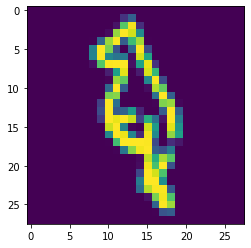

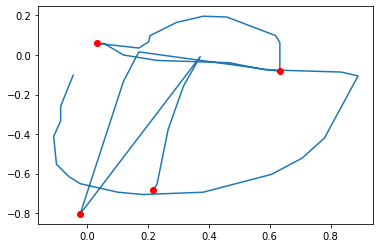

In [ ]:
#@title Check an example

pixel_train_example = x_pixel_data[0][11123]
vector_train_example = x_vector_data[0][11111]
y_example = y_data[0][11111]

print(classes[y_example])
plt.imshow(pixel_train_example.reshape(28,28))
plt.show()

# Ink representation
visualize_ink_image(x_ink_data[0][11111])

#### Pixel Data

In [ ]:
# Train, dev, devtest, test pixel data
train_x_pixel, dev_x_pixel, devtest_x_pixel, test_x_pixel= x_pixel_data

#### Vectors Data

In [ ]:
# Train, dev, devtest, test vectors data
train_x_vector, dev_x_vector, devtest_x_vector, test_x_vector= x_vector_data

#### Ink Data

In [ ]:
# Train, dev, devtest, test ink data
train_x_ink, dev_x_ink, devtest_x_ink, test_x_ink = x_ink_data

#### Labels

In [ ]:
train_y, dev_y, devtest_y, test_y = y_data

In [ ]:
print(train_y.shape, dev_y.shape, devtest_y.shape, test_y.shape)

(75000,) (50000,) (50000,) (75000,)


####  Labeled Data
All of these labeled datasets are of size 1000, though with varying number of classes.

In [ ]:
# dictionary of labeled data of various number classes (from 10 to 50)
labeled_data = sample_labeled_data(devtest_x_pixel, devtest_x_ink, devtest_y, 1000)

In [ ]:
# labeled test data with various number of classes
labeled_test_data = sample_labeled_data(test_x_pixel, test_x_ink, test_y, 1000, test=True)

In [ ]:
test_results = {}

# Baseline SVM on ALL train & dev Labeled Data

In [ ]:
"""t0 = time.time()
supervised_best_error_dev, pred_dev_y = linear_svm(
        train_x_pixel[:5000], train_y[:5000],
        dev_x_pixel[:5000], dev_y[:5000],
        test_x_pixel
    )
    
m = confusion_matrix(dev_y[:5000], pred_dev_y)
p = ConfusionMatrixDisplay(m, classes[:100])
p.plot(include_values=False, xticks_rotation="vertical")
plt.show()
t1 = time.time()
print("Time taken:", t1-t0)"""

't0 = time.time()\nsupervised_best_error_dev, pred_dev_y = linear_svm(\n        train_x_pixel[:5000], train_y[:5000],\n        dev_x_pixel[:5000], dev_y[:5000],\n        test_x_pixel\n    )\n    \nm = confusion_matrix(dev_y[:5000], pred_dev_y)\np = ConfusionMatrixDisplay(m, classes[:100])\np.plot(include_values=False, xticks_rotation="vertical")\nplt.show()\nt1 = time.time()\nprint("Time taken:", t1-t0)'

# Baseline SVM with Labeled Data
1,000 labeled samples from devtest, no unlabeled data, using all 784 dimensions

### Train & Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), no unlabeled data (so no representation learning at all), using all 784 dimensions pixel data

Performing linear SVM!
Selected classifier with best dev error 0.583333


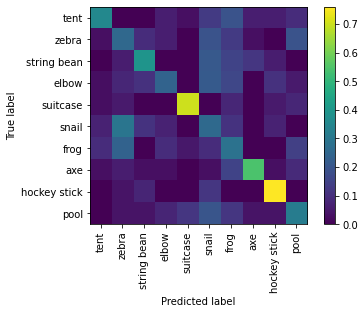

Performing linear SVM!
Selected classifier with best dev error 0.816667


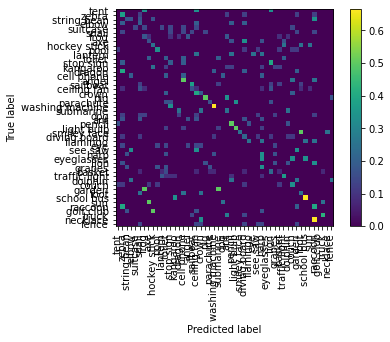

In [ ]:
dev_err_baseline = {}
test_results["baseline"] = {}
for c in [10,50]:
  labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data[c]
  labeled_test_pixel, _, _ = labeled_test_data[c]

  # print([classes[i] for i in set(labeled_y)])
  baseline_best_error_dev, pred_dev_y, test_pred = linear_svm(
          labeled_x_pixel, labeled_y, 
          labeled_x_pixel_dev, labeled_y_dev, 
          labeled_test_pixel
      )
  
  m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
  p = ConfusionMatrixDisplay(m, classes[:c])
  p.plot(include_values=False, xticks_rotation="vertical")
  plt.show()
  dev_err_baseline[c] = baseline_best_error_dev
  test_results["baseline"][c] = test_pred

### Plot and Analysis

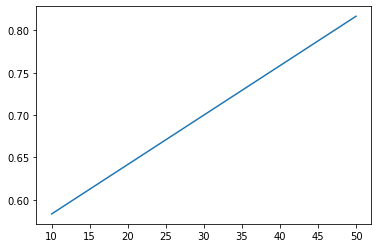

In [ ]:
x, y = zip(*sorted(dev_err_baseline.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_baseline

{10: 0.5833333333333334, 50: 0.8166666666666667}

# Basic Representation Learning Experiments

## PCA

### Evaluate 0
1,000 labeled samples from devtest (for classification: split into train & dev), no unlabeled data but conducted PCA on the 1,000 labeled samples, using PCA 50 dimensions

Performing linear SVM!
Selected classifier with best dev error 0.433333


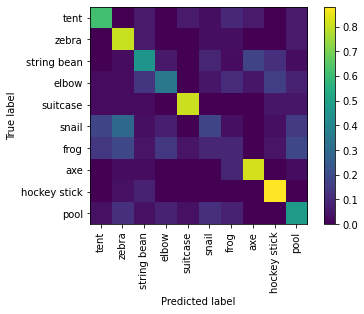

Performing linear SVM!


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Selected classifier with best dev error 0.790000


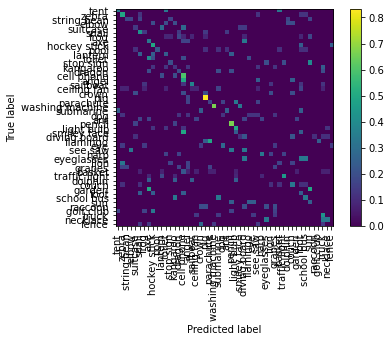

In [ ]:
dev_err_reduced0 = {}
test_results["pca_labeled_only"] = {}
for c in [10, 50]:
    labeled_x_pixel, labeled_x_ink, labeled_y, labeled_x_pixel_dev, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, _, _ = labeled_test_data[c]

    pca = PCA(n_components=50)
    train_x_features = pca.fit_transform(labeled_x_pixel)
    dev_x_features = pca.transform(labeled_x_pixel_dev)
    test_x_features = pca.transform(labeled_test_pixel)

    reduced_best_error_dev, pred_dev_y, test_pred = linear_svm(
        train_x_features, labeled_y, 
        dev_x_features, labeled_y_dev, 
        test_x_features
    )    
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    dev_err_reduced0[c] = reduced_best_error_dev
    test_results["pca_labeled_only"][c] = test_pred

### Plot 0

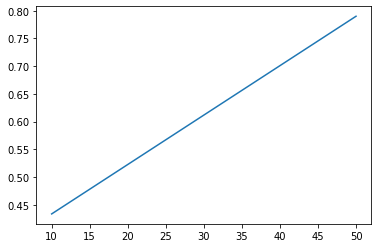

In [ ]:
x, y = zip(*sorted(dev_err_reduced0.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_reduced0

{10: 0.43333333333333335, 50: 0.79}

### Evaluate 1
10,000 labeled samples from devtest (split into train & dev), no unlabeled data but conducted PCA on the 10,000 labeled samples, using PCA 50 dimensions

In [ ]:
labeled_data_10000 = sample_labeled_data(devtest_x_pixel, devtest_x_ink, devtest_y, 10000)

dev_err_reduced = {}
for c in range(10,51,5):
    print("Number of classes = {}".format(c))
    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data_10000[c]
    
    pca = PCA(n_components=50)
    train_x_features = pca.fit_transform(labeled_x_pixel)
    dev_x_features = pca.transform(labeled_x_pixel_dev)
    test_x_features = pca.transform(test_x_pixel)   
    
    reduced_best_error_dev, pred_dev_y = linear_svm(
        train_x_features, labeled_y, 
        dev_x_features, labeled_y_dev, 
        dev_x_features
    )    
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()

    dev_err_reduced[c] = reduced_best_error_dev


Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.376459


ValueError: ignored

### Plot 1

In [ ]:
x, y = zip(*sorted(dev_err_reduced.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_reduced

### Evaluate 2
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev for PCA, using PCA 50 dimensions

Performing linear SVM!
Selected classifier with best dev error 0.460000


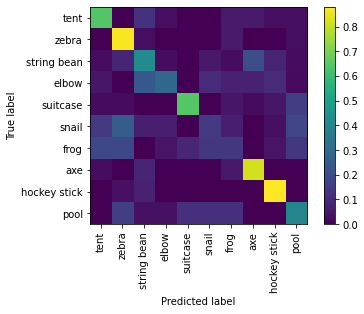

Performing linear SVM!


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Selected classifier with best dev error 0.793333


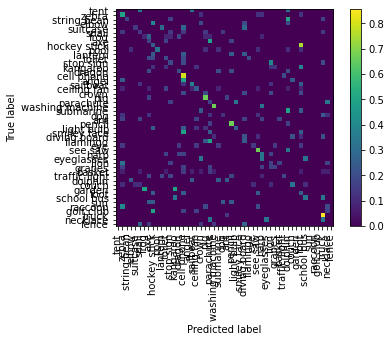

In [ ]:
# Linear Semi-Supervised PCA Experiment
dev_err_pca = {}
test_results["pca_with_unlabeled"] = {}
pca = PCA(n_components=50)
pca.fit_transform(train_x_pixel)

for c in [10,50]:
    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, _, _ = labeled_test_data[c]
    train_x_features = pca.transform(labeled_x_pixel)
    dev_x_features = pca.transform(labeled_x_pixel_dev)
    test_x_features = pca.transform(labeled_test_pixel)

    reduced_best_error_dev, pred_dev_y, test_pred = linear_svm(
        train_x_features, labeled_y, 
        dev_x_features, labeled_y_dev, 
        test_x_features
    )    
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()

    dev_err_pca[c] = reduced_best_error_dev
    test_results["pca_with_unlabeled"][c] = test_pred

### Plot 2

In [ ]:
x, y = zip(*sorted(dev_err_pca.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_pca

### Evaluate 3
10,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev for PCA, using PCA 50 dimensions

In [ ]:
# Linear Semi-Supervised PCA Experiment
dev_err_pca = {}
pca = PCA(n_components=50)
pca.fit_transform(train_x_pixel)

for c in range(10,51,5):
    print("Number of classes = {}".format(c))
    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data_10000[c]
    train_x_features = pca.transform(labeled_x_pixel)
    dev_x_features = pca.transform(labeled_x_pixel_dev)
    test_x_features = pca.transform(test_x_pixel)

    reduced_best_error_dev, pred_dev_y = linear_svm(
        train_x_features, labeled_y, 
        dev_x_features, labeled_y_dev, 
        dev_x_features
    )    
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()

    dev_err_pca[c] = pca_best_error_dev

### Plot 3

In [ ]:
x, y = zip(*sorted(dev_err_pca.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_pca

## Kernel PCA (I'm suggesting that we drop this)

In [ ]:
# Kernel PCA experiment

train_x_subset = train_x_sample[:10000]
train_y_subset = train_y_sample[:10000]
for n in [5]:
    print("Running {} components".format(n))
    pca = KernelPCA(n_components=n, kernel="rbf")
    train_x_features = pca.fit_transform(train_x_subset)
    dev_x_features = pca.transform(dev_x_sample)
    test_x_features = dev_x_features

    reduced_best_error_dev, reduced_pred = linear_svm(
        train_x_features, train_y_subset, 
        dev_x_features, dev_y_sample, 
        test_x_features
    )

# Self-supervised Learning

## Geometric deformation

In [ ]:
# Load an example
pixel_train_example = x_pixel_data[0][11111]
vector_train_example = x_vector_data[0][11111]
ink_train_example = x_ink_data[0][11111]
y_example = y_data[0][11111]

In [ ]:
# Create a dataset of geometric deformations and their labels
labels = ["O", "R90", "R180", "R270", "VC", "HC"] # VC: vertical compression, HC: horizontal compression

### Pixel deformation

In [ ]:
def rotate_sketch_pixel(sketch_pixel): 
    """
    Rotate pixel data (clockwise) 90, 180, 270 degrees

    Args: 
        sketch_pixel: numpy array of size (1, 784) taken from a pixel data
    
    Output: array of four rotations in numpy 28x28 format
    """

    img = sketch_pixel.reshape((28, 28))
    r90 = ndimage.rotate(img, -90, reshape=False)
    r180 = ndimage.rotate(img, -180, reshape=False)
    r270 = ndimage.rotate(img, -270, reshape=False)
    return np.array([img, r90, r180, r270])
  

def compress_sketch_pixel(sketch_pixel): 
    """
    Compress pixel data vertically and horizontally (resize) and then padding

    Args: 
        sketch_pixel: numpy array of size (1, 784) taken from a pixel data

    Output: array of original, horizontal, and vertical compression in numpy 28x28 format
    """

    img = sketch_pixel.reshape((28, 28))
    horz = cv2.resize(img, dsize=(14, 28), interpolation=cv2.INTER_CUBIC)
    horz = cv2.copyMakeBorder(horz, 0, 0, 7, 7, cv2.BORDER_CONSTANT, value=[0,0,0])
    vert = cv2.resize(img, dsize=(28, 14), interpolation=cv2.INTER_CUBIC)
    vert = cv2.copyMakeBorder(vert, 7, 7, 0, 0, cv2.BORDER_CONSTANT, value=[0,0,0])
    return np.array([img, horz, vert])



basket


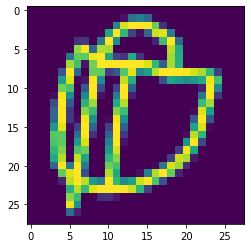

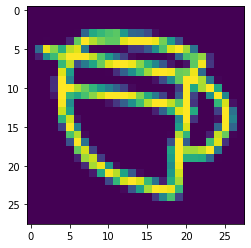

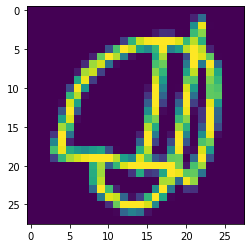

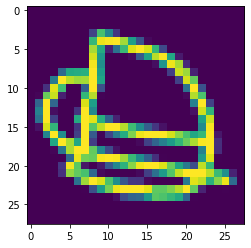

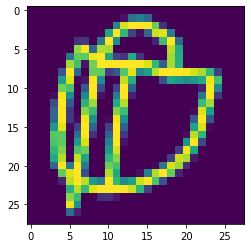

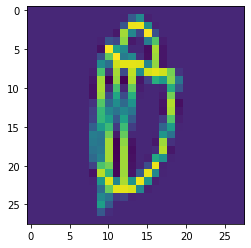

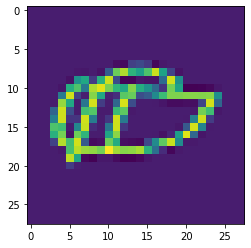

In [ ]:
# Rotation on Example
print(classes[y_example])
rotated_examples = rotate_sketch_pixel(pixel_train_example)
for img in rotated_examples: 
    plt.imshow(img)
    plt.show()

compressed_examples = compress_sketch_pixel(pixel_train_example)
for img in compressed_examples: 
    plt.imshow(img)
    plt.show()

In [ ]:
# Create dataset of deformed pixel images (formatted as pytorch tensor)

rot_pixel_deform = np.apply_along_axis(rotate_sketch_pixel, 1, train_x_pixel)
rot_pixel_deform = np.concatenate(rot_pixel_deform, axis=0)
print("Finished rotation")
comp_pixel_deform = np.apply_along_axis(compress_sketch_pixel, 1, train_x_pixel)
comp_pixel_deform = np.concatenate(comp_pixel_deform, axis=0)
print("Finished compression")

y_rot_deform = np.array([0,1,2,3] * train_x_pixel.shape[0])
y_comp_deform = np.array([0,1,2] * train_x_pixel.shape[0])

# generate random permutation
np.random.seed(2000)
rot_permutation = np.random.permutation(len(y_rot_deform))
np.random.seed(3000)
comp_permutation = np.random.permutation(len(y_comp_deform))

# apply random permutation
y_rot_deform = y_rot_deform[rot_permutation]
y_comp_deform = y_comp_deform[comp_permutation]
rot_pixel_deform = rot_pixel_deform[rot_permutation]
comp_pixel_deform = comp_pixel_deform[comp_permutation]

print(rot_pixel_deform.shape)
print(comp_pixel_deform.shape)


Finished rotation
Finished compression
(300000, 28, 28)
(225000, 28, 28)


In [ ]:
# Convert to the correct pytorch tensor format

# tensor-ize
y_rot_deform = torch.from_numpy(y_rot_deform)
y_comp_deform = torch.from_numpy(y_comp_deform)
rot_pixel_deform = torch.from_numpy(rot_pixel_deform).float()
comp_pixel_deform = torch.from_numpy(comp_pixel_deform).float()


# unsqueeze
rot_pixel_deform = torch.unsqueeze(rot_pixel_deform, 1)
comp_pixel_deform = torch.unsqueeze(comp_pixel_deform, 1)
print(rot_pixel_deform.shape)
print(comp_pixel_deform.shape)


train_rot_pixel_deform, dev_rot_pixel_deform = rot_pixel_deform[:-1000], rot_pixel_deform[-1000:]
train_comp_pixel_deform, dev_comp_pixel_deform = comp_pixel_deform[:-1000], comp_pixel_deform[-1000:]

train_y_rot_pixel_deform, dev_y_rot_pixel_deform = y_rot_deform[:-1000], y_rot_deform[-1000:]
train_y_comp_pixel_deform, dev_y_comp_pixel_deform = y_comp_deform[:-1000], y_comp_deform[-1000:]

print(train_rot_pixel_deform.shape, dev_rot_pixel_deform.shape)
print(train_comp_pixel_deform.shape, dev_comp_pixel_deform.shape)
print(train_y_rot_pixel_deform.shape, dev_y_rot_pixel_deform.shape)
print(train_y_comp_pixel_deform.shape, dev_y_comp_pixel_deform.shape)

torch.Size([300000, 1, 28, 28])
torch.Size([225000, 1, 28, 28])
torch.Size([299000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])
torch.Size([224000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])
torch.Size([299000]) torch.Size([1000])
torch.Size([224000]) torch.Size([1000])


### Ink deformation

In [ ]:
def rotate_sketch_ink(sketch_ink): 
    """
    Given an ink format of a sketch, rotate it (clockwise) and return all four rotations

    Args: 
        sketch_ink: numpy array of size (# of strokes, 3) taken from an ink data
    
    Output: list of 4 numpy arrays, each denoting a rotation of ink
    """
    r90_picture = sketch_ink @ np.array([[0,1,0],[-1,0,0],[0,0,1]])
    r180_picture = sketch_ink @ np.array([[-1,0,0],[0,-1,0],[0,0,1]])
    r270_picture = sketch_ink @ np.array([[0,-1,0],[1,0,0],[0,0,1]])
    return [sketch_ink, r90_picture, r180_picture, r270_picture]

def compress_sketch_ink(sketch_ink): 
    """
    Compress a ink format of a sketch vertically and horizontally
    """
    vertical_compression = np.zeros(sketch_ink.shape)
    vertical_compression[:, 0] = sketch_ink[:, 0]
    vertical_compression[:, 1] = sketch_ink[:, 1] * 0.5
    vertical_compression[:, 2] = sketch_ink[:, 2]

    horizontal_compression = np.zeros(sketch_ink.shape)
    horizontal_compression[:, 0] = sketch_ink[:, 0] * 0.5
    horizontal_compression[:, 1] = sketch_ink[:, 1]
    horizontal_compression[:, 2] = sketch_ink[:, 2]

    return [sketch_ink, vertical_compression, horizontal_compression]

def ink_to_tensor(picture):
    """
    Convert an np.array formatted list of strokes to a pytorch tensor
    Args: 
        pictures: list of strokes [[[delta_x, delta_y, p],...], ...]
    
    Returns: tensor of size # of strokes x 1 x 3
    """
    tensor = torch.FloatTensor(picture)
    return torch.unsqueeze(tensor, 1)

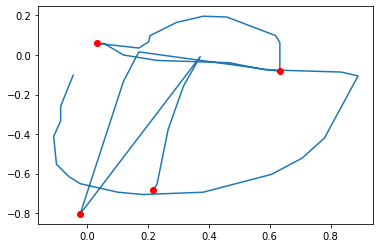

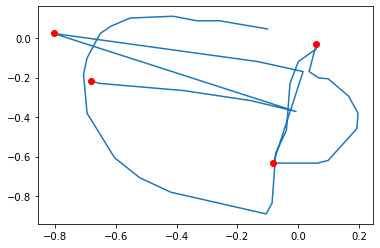

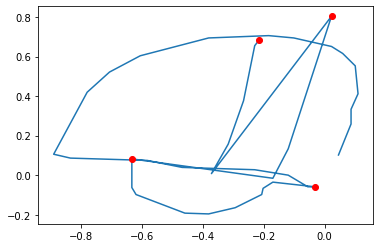

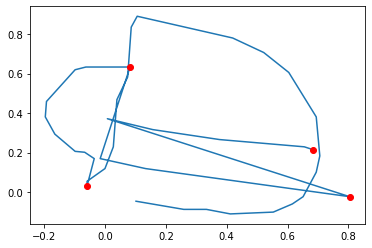

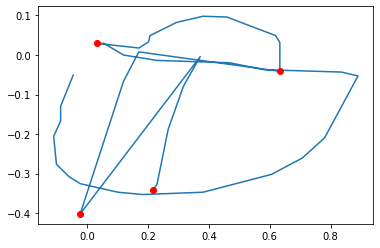

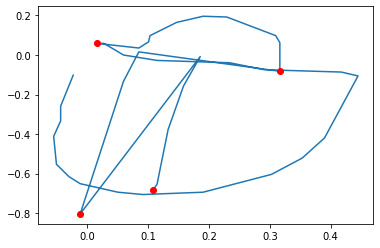

In [ ]:
# Example
sketch_ink, r90_picture, r180_picture, r270_picture = rotate_sketch_ink(ink_train_example)
sketch_ink, vertical_compression, horizontal_compression = compress_sketch_ink(ink_train_example)

visualize_ink_image(sketch_ink)
visualize_ink_image(r90_picture)
visualize_ink_image(r180_picture)
visualize_ink_image(r270_picture)
visualize_ink_image(vertical_compression)
visualize_ink_image(horizontal_compression)

In [ ]:
# Create dataset of deformed ink images (formatted as list of tensors)

rot_ink_deform = []
comp_ink_deform = []
y_rot_ink_deform = []
y_comp_ink_deform = []
for pic in  train_x_ink: 
    rot = rotate_sketch_ink(pic)
    comp = compress_sketch_ink(pic)
    rot_ink_deform.extend(rot)
    comp_ink_deform.extend(comp)
    y_rot_ink_deform.extend([0,1,2,3])
    y_comp_ink_deform.extend([0,1,2])

# Use the same permutation as the pixel deformation

# rotation ink + compression ink deformation data generation
rot_ink_deform = [ink_to_tensor(rot_ink_deform[i]) for i in rot_permutation]
comp_ink_deform = [ink_to_tensor(comp_ink_deform[i]) for i in comp_permutation]
train_rot_ink_deform, dev_rot_ink_deform = rot_ink_deform[:-1000], rot_ink_deform[-1000:]
train_comp_ink_deform, dev_comp_ink_deform = comp_ink_deform[:-1000], comp_ink_deform[-1000:]

y_rot_ink_deform = torch.IntTensor([(y_rot_ink_deform[i]) for i in rot_permutation])
y_comp_ink_deform = torch.IntTensor([(y_comp_ink_deform[i]) for i in comp_permutation])
train_y_rot_ink_deform, dev_y_rot_ink_deform = y_rot_ink_deform[:-1000], y_rot_ink_deform[-1000:]
train_y_comp_ink_deform, dev_y_comp_ink_deform = y_comp_ink_deform[:-1000], y_comp_ink_deform[-1000:]

In [ ]:
len(train_rot_ink_deform), len(train_y_rot_ink_deform)

(299000, 299000)

In [ ]:
# move to gpu
if torch.cuda.is_available(): 
    device = torch.device("cuda")

    train_rot_ink_deform = [item.cuda() for item in train_rot_ink_deform]
    dev_rot_ink_deform = [item.cuda() for item in dev_rot_ink_deform]
    train_comp_ink_deform = [item.cuda() for item in train_comp_ink_deform]
    dev_comp_ink_deform = [item.cuda() for item in dev_comp_ink_deform]

    train_y_rot_ink_deform = train_y_rot_ink_deform.cuda()
    dev_y_rot_ink_deform = dev_y_rot_ink_deform.cuda()
    train_y_comp_ink_deform = train_y_comp_ink_deform.cuda()
    dev_y_comp_ink_deform = dev_y_comp_ink_deform.cuda()


    train_rot_pixel_deform = train_rot_pixel_deform.cuda()
    dev_rot_pixel_deform = dev_rot_pixel_deform.cuda()
    train_comp_pixel_deform = train_comp_pixel_deform.cuda()
    dev_comp_pixel_deform = dev_comp_pixel_deform.cuda()

    train_y_rot_pixel_deform = train_y_rot_pixel_deform.cuda()
    dev_y_rot_pixel_deform = dev_y_rot_pixel_deform.cuda()
    train_y_comp_pixel_deform = train_y_comp_pixel_deform.cuda()
    dev_y_comp_pixel_deform = dev_y_comp_pixel_deform.cuda()
else: 
    device = torch.device("cpu")

## RNN on Ink
Referencing an RNN PyTorch tutorial: 
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

An existing Quick, Draw! RNN implementation on PyTorch: 
https://github.com/alexis-jacq/Pytorch-Sketch-RNN/blob/master/sketch_rnn.py

#### Setup

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [ ]:
def extract_feature_rnn(model, data): 
    """
    Extract features from the intermediate hidden layer

    Args: 
        model: the trained RNN model ("rot_rnn" if rotation, "comp_rnn" if compression)
        data: sequences of data (list of sketches in ink format)
    
    Output: (numpy array) features of size (# of sketches, hidden dimension)
    """
    
    tensored_data = [ink_to_tensor(ink).cuda() for ink in data]
    outputs = []
    model.eval()
    for ink in tensored_data: 
        hidden = model.initHidden().cuda()
        for stroke in ink: 
            output, hidden = model.forward(stroke, hidden)
        outputs.append(hidden)
    outputs = torch.stack((outputs)).cuda()
    return torch.squeeze(outputs, 1).detach()

In [ ]:
print(train_y_rot_pixel_deform)

### Rotation RNN

#### Train

In [ ]:
rot_labels = ["O", "R90", "R180", "R270"]

In [ ]:
hidden = torch.zeros(1, 128).cuda()
rot_rnn = RNN(3, 128, 4)
rot_rnn = rot_rnn.to(device)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return rot_labels[category_i], category_i

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.001

def rot_train(category_tensor, ink_tensor):
    hidden = rot_rnn.initHidden().cuda()

    rot_rnn.zero_grad()

    for i in range(ink_tensor.size()[0]):
        output, hidden = rot_rnn(ink_tensor[i], hidden)
        # print(output.device, hidden.device)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rot_rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
def generate_ith_rot_example(i): 
    category = rot_labels[train_y_rot_ink_deform[i]]
    ink = train_rot_ink_deform[i]
    category_tensor = torch.tensor([train_y_rot_ink_deform[i]], dtype=torch.long).cuda()
    ink_tensor = train_rot_ink_deform[i]
    return category, ink, category_tensor, ink_tensor

In [ ]:
def evaluate_on_dev(model, dev_set, labels):
    total = len(dev_set)
    correct = 0

    for j, ink_tensor in enumerate(dev_set):
        hidden = rot_rnn.initHidden().cuda()
        for i in range(ink_tensor.size()[0]): 
            output, hidden = model(ink_tensor[i], hidden)
        predicted = torch.argmax(output)
        correct += (labels[j] == predicted)
    return correct/total

In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000
eval_every = 5000


# Keep track of losses for plotting
current_loss = 0
rot_rnn_losses = []
rot_rnn_accuracies = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(n_iters):
    category, ink, category_tensor, ink_tensor = generate_ith_rot_example(iter)
    # print(category_tensor.device, ink_tensor.device)
    output, loss = rot_train(category_tensor, ink_tensor)
    if not loss: 
        print(output, loss)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))

    # Evaluate accuracy of current model on dev set
    if iter % eval_every == 0: 
        accuracy = evaluate_on_dev(rot_rnn, dev_rot_ink_deform, dev_y_rot_ink_deform)
        print("dev accuracy = %.4f percent" % (100 * accuracy))
        rot_rnn_accuracies.append(accuracy)

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        rot_rnn_losses.append(current_loss / plot_every)
        current_loss = 0


0 0% (0m 0s) 1.3989 / R180 ✗ (R270)
0 0% (0m 0s) 1.3989 / R180 ✗ (R270)
dev accuracy = 26.1000 percent
dev accuracy = 26.1000 percent
5000 5% (1m 23s) 1.4385 / R90 ✗ (R270)
5000 5% (1m 23s) 1.4385 / R90 ✗ (R270)
dev accuracy = 25.8000 percent
dev accuracy = 25.8000 percent
10000 10% (2m 45s) 1.4200 / R270 ✗ (R180)
10000 10% (2m 45s) 1.4200 / R270 ✗ (R180)
dev accuracy = 24.7000 percent
dev accuracy = 24.7000 percent
15000 15% (4m 8s) 1.3836 / R270 ✗ (O)
15000 15% (4m 8s) 1.3836 / R270 ✗ (O)
dev accuracy = 25.8000 percent
dev accuracy = 25.8000 percent
20000 20% (5m 31s) 1.3745 / R270 ✗ (R90)
20000 20% (5m 31s) 1.3745 / R270 ✗ (R90)
dev accuracy = 27.1000 percent
dev accuracy = 27.1000 percent
25000 25% (6m 53s) 1.4013 / O ✗ (R90)
25000 25% (6m 53s) 1.4013 / O ✗ (R90)
dev accuracy = 25.5000 percent
dev accuracy = 25.5000 percent
30000 30% (8m 15s) 1.4144 / R90 ✗ (R270)
30000 30% (8m 15s) 1.4144 / R90 ✗ (R270)
dev accuracy = 26.5000 percent
dev accuracy = 26.5000 percent
35000 35% (9m 37

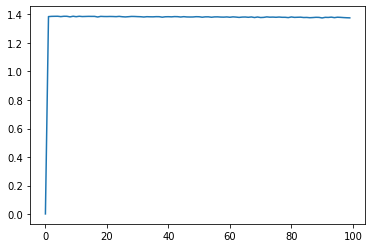

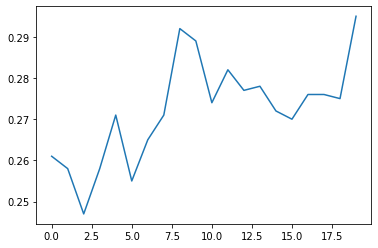

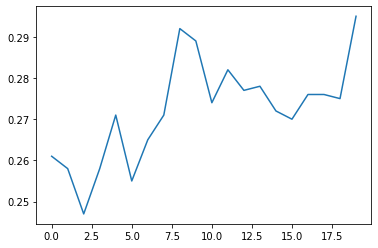

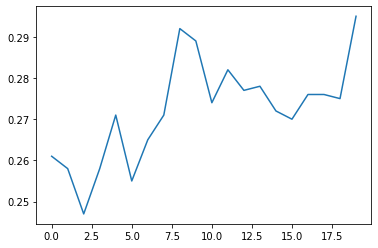

In [ ]:
plt.figure()
plt.plot(rot_rnn_losses)
plt.show()
plt.plot(rot_rnn_accuracies)
plt.show()

#### Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev to construct an RNN (rotation)

torch.Size([700, 128])
torch.Size([300, 128])
Performing linear SVM!
Selected classifier with best dev error 0.836667


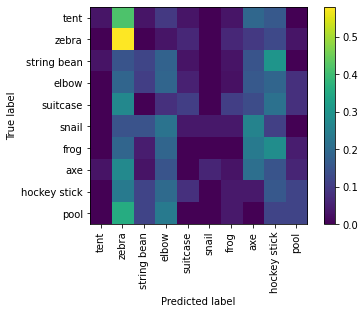

torch.Size([700, 128])
torch.Size([300, 128])
Performing linear SVM!
Selected classifier with best dev error 0.943333


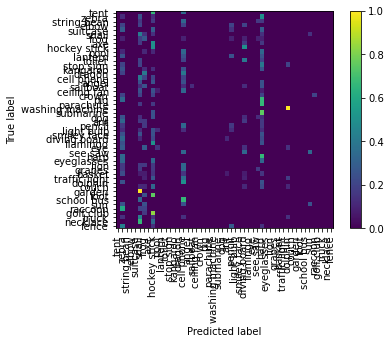

In [ ]:
dev_err_rnn_rot_self = {}
test_results["rotation_rnn"] = {}
for c in [10,50]:

    _, labeled_x_ink, labeled_y, _, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    _, labeled_test_ink, _ = labeled_test_data[c]
    
    rot_ink_features = extract_feature_rnn(rot_rnn, labeled_x_ink).cpu()
    print(rot_ink_features.shape)
    dev_rot_ink_features = extract_feature_rnn(rot_rnn, labeled_x_ink_dev).cpu()
    print(dev_rot_ink_features.shape)
    test_rot_ink_features = extract_feature_rnn(rot_rnn, labeled_test_ink).cpu()

    rnn_rot_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        rot_ink_features, labeled_y, 
        dev_rot_ink_features, labeled_y_dev, 
        test_rot_ink_features
    )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()

    dev_err_rnn_rot_self[c] = rnn_rot_self_best_error_dev
    test_results["rotation_rnn"][c] = test_pred

#### Plot

In [ ]:
x, y = zip(*sorted(dev_err_rnn_rot_self.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_rnn_rot_self

### Compression RNN

#### Train

In [ ]:
comp_labels = ["O", "VC", "HC"]
hidden = torch.zeros(1, n_hidden)
comp_rnn = RNN(3, n_hidden, 3)
comp_rnn = comp_rnn.to(device)

def categoryFromOutputComp(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return comp_labels[category_i], category_i

learning_rate = 0.005

def comp_train(category_tensor, ink_tensor):
    hidden = comp_rnn.initHidden().cuda()

    comp_rnn.zero_grad()

    for i in range(ink_tensor.size()[0]):
        output, hidden = comp_rnn(ink_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in comp_rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def generate_ith_comp_example(i): 
    category = comp_labels[train_y_comp_ink_deform[i]]
    ink = train_comp_ink_deform[i]
    category_tensor = torch.tensor([train_y_comp_ink_deform[i]], dtype=torch.long).cuda()
    ink_tensor = train_comp_ink_deform[i]
    return category, ink, category_tensor, ink_tensor

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []
accuracies = []

start = time.time()

for iter in range(n_iters):
    category, ink, category_tensor, ink_tensor = generate_ith_comp_example(iter)
    output, loss = comp_train(category_tensor, ink_tensor)
    if not loss: 
        print(output, loss)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutputComp(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))

    # Evaluate accuracy of current model on dev set
    if iter % eval_every == 0: 
        accuracy = evaluate_on_dev(comp_rnn, dev_comp_ink_deform, dev_y_comp_ink_deform)
        print("dev accuracy = %.4f percent" % (100 * accuracy))
        accuracies.append(accuracy)

    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


0 0% (0m 0s) 1.1783 / VC ✗ (O)
dev accuracy = 32.8000 percent
5000 5% (1m 21s) 1.1774 / HC ✗ (O)
dev accuracy = 31.9000 percent
10000 10% (2m 45s) 1.0555 / VC ✓
dev accuracy = 34.6000 percent
15000 15% (4m 8s) 0.9498 / HC ✓
dev accuracy = 32.6000 percent
20000 20% (5m 32s) 1.0812 / HC ✗ (VC)
dev accuracy = 35.9000 percent
25000 25% (6m 55s) 0.9436 / VC ✓
dev accuracy = 33.1000 percent
30000 30% (8m 19s) 1.1043 / HC ✗ (VC)
dev accuracy = 33.8000 percent
35000 35% (9m 41s) 1.0432 / HC ✗ (O)
dev accuracy = 33.5000 percent
40000 40% (11m 3s) 1.1688 / VC ✗ (O)
dev accuracy = 36.1000 percent
45000 45% (12m 26s) 1.1216 / VC ✗ (HC)
dev accuracy = 37.2000 percent
50000 50% (13m 49s) 1.0308 / HC ✓
dev accuracy = 31.8000 percent
55000 55% (15m 12s) 1.1220 / HC ✗ (VC)
dev accuracy = 31.3000 percent
60000 60% (16m 35s) 1.0866 / O ✗ (VC)
dev accuracy = 31.0000 percent
65000 65% (17m 59s) 1.1383 / HC ✗ (O)
dev accuracy = 31.0000 percent
70000 70% (19m 23s) 1.0192 / O ✓
dev accuracy = 34.0000 percent


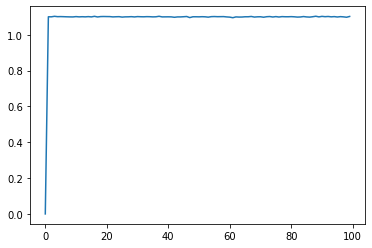

In [ ]:
plt.figure()
plt.plot(all_losses)

#### Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev to construct an RNN (compression)

torch.Size([700, 128])
torch.Size([300, 128])
Performing linear SVM!
Selected classifier with best dev error 0.846667


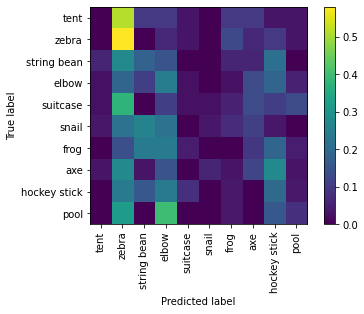

torch.Size([700, 128])
torch.Size([300, 128])
Performing linear SVM!
Selected classifier with best dev error 0.953333


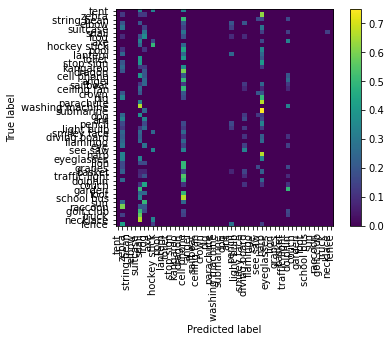

In [ ]:
dev_err_rnn_comp_self = {}
test_results["compression_rnn"] = {}
for c in [10, 50]:
    _, labeled_x_ink, labeled_y, _, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    _, labeled_test_ink, _ = labeled_test_data[c]
    
    comp_ink_features = extract_feature_rnn(comp_rnn, labeled_x_ink).cpu()
    print(comp_ink_features.shape)
    dev_comp_ink_features = extract_feature_rnn(comp_rnn, labeled_x_ink_dev).cpu()
    print(dev_comp_ink_features.shape)
    test_comp_ink_features = extract_feature_rnn(comp_rnn, labeled_test_ink).cpu()

    rnn_comp_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        comp_ink_features, labeled_y, 
        dev_comp_ink_features, labeled_y_dev, 
        test_comp_ink_features
    )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    
    dev_err_rnn_comp_self[c] = rnn_comp_self_best_error_dev
    test_results["compression_rnn"][c] = test_pred

#### Plot

In [ ]:
x, y = zip(*sorted(dev_err_rnn_comp_self.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_rnn_comp_self

### Combining RNN rotation and compression

Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.840000


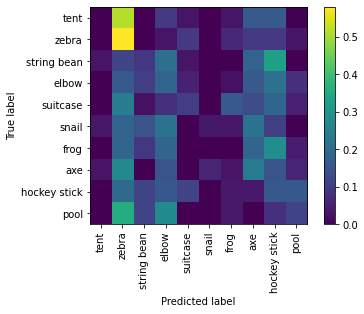

Number of classes = 50
Performing linear SVM!
Selected classifier with best dev error 0.956667


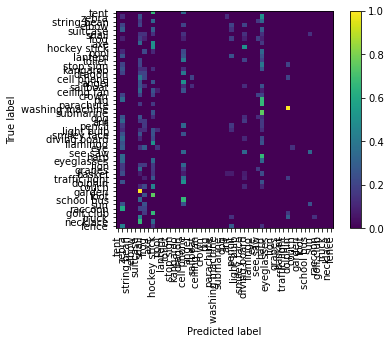

In [ ]:
dev_err_rnn_self = {}
test_results["rotation_compression_rnn"] = {}
for c in [10, 50]:
    print("Number of classes = {}".format(c))
    _, labeled_x_ink, labeled_y,  _, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    _, labeled_test_ink, _ = labeled_test_data[c]

    rot_ink_features = extract_feature_rnn(rot_rnn, labeled_x_ink).cpu()
    dev_rot_ink_features = extract_feature_rnn(rot_rnn, labeled_x_ink_dev).cpu()
    test_rot_ink_features = extract_feature_rnn(rot_rnn, labeled_test_ink).cpu()

    comp_ink_features = extract_feature_rnn(comp_rnn, labeled_x_ink).cpu()
    dev_comp_ink_features = extract_feature_rnn(comp_rnn, labeled_x_ink_dev).cpu()
    test_comp_ink_features = extract_feature_rnn(comp_rnn, labeled_test_ink).cpu()

    rnn_ink_features = np.concatenate((rot_ink_features, comp_ink_features), axis=1)
    dev_rnn_ink_features = np.concatenate((dev_rot_ink_features, dev_comp_ink_features), axis=1)
    test_rnn_ink_features = np.concatenate((test_rot_ink_features, test_comp_ink_features), axis=1)

    rnn_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        rnn_ink_features, labeled_y, 
        dev_rnn_ink_features, labeled_y_dev, 
        test_rnn_ink_features
    )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    
    dev_err_rnn_self[c] = rnn_comp_self_best_error_dev
    test_results["rotation_compression_rnn"][c] = test_pred


## CNN on Pixel
A tutorial: https://medium.com/swlh/pytorch-real-step-by-step-implementation-of-cnn-on-mnist-304b7140605a
Intermediate layer feature extraction (hook): https://towardsdatascience.com/the-one-pytorch-trick-which-you-should-know-2d5e9c1da2ca

#### Setup

In [ ]:
# DataLoader

# batch_size, epoch and iteration
batch_size = 1


# Pytorch train and test sets
rot_pixel_train = torch.utils.data.TensorDataset(train_rot_pixel_deform, train_y_rot_pixel_deform)
comp_pixel_train = torch.utils.data.TensorDataset(train_comp_pixel_deform, train_y_comp_pixel_deform)
rot_pixel_dev = torch.utils.data.TensorDataset(dev_rot_pixel_deform, dev_y_rot_pixel_deform)
comp_pixel_dev = torch.utils.data.TensorDataset(dev_comp_pixel_deform, dev_y_comp_pixel_deform)

# data loader
rot_train_loader = torch.utils.data.DataLoader(rot_pixel_train, batch_size = batch_size, shuffle = False)
comp_train_loader = torch.utils.data.DataLoader(comp_pixel_train, batch_size = batch_size, shuffle = False)
rot_dev_loader = torch.utils.data.DataLoader(rot_pixel_dev, batch_size = batch_size, shuffle = False)
comp_dev_loader = torch.utils.data.DataLoader(comp_pixel_dev, batch_size = batch_size, shuffle = False)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, output_size):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.relu3 = nn.ReLU() 

        # Fully connected 2
        self.fc2 = nn.Linear(64, output_size)
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)

        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        #Flatten
        out = out.view(out.size(0), -1)
        out = out.view(out.size(0), -1)

        #Dense
        hidden = self.fc1(out)
        out = self.relu3(hidden)
        out = self.fc2(out)
        
        return out, hidden

In [ ]:
def extract_feature_cnn(model, data): 
    """
    Extract features from the intermediate hidden layer

    Args: 
        model: the trained CNN model ("rot_cnn" if rotation, "comp_cnn" if compression)
        data: pixel formatted data, such as labeled_x_pixel
    
    Output: (numpy array) features of size (# of sketches, hidden dimension)
    """
    model.eval()
    outputs = []
    for pix in data: 
        tensored_data = torch.from_numpy(pix.reshape((28,28))).float().cuda()
        tensored_data = torch.unsqueeze(tensored_data, 0)
        tensored_data = torch.unsqueeze(tensored_data, 0)
        _, hidden = model(tensored_data)
        outputs.append(hidden)
    outputs = torch.stack((outputs))
    return torch.squeeze(outputs, 1).detach()

### Rotation CNN

#### Train

In [ ]:
#Definition of hyperparameters
#n_iters = 300000 #changed from 180000 with new classes
#num_epochs = n_iters / (len(rot_pixel_train) / batch_size)
#num_epochs = int(num_epochs)
n_iters = 5000
num_epochs = 20

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

In [ ]:
# SGD Optimizer
learning_rate = 0.001
rot_cnn = CNNModel(4)
rot_cnn = rot_cnn.to(device)
optimizer = torch.optim.SGD(rot_cnn.parameters(), lr=learning_rate)

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    indices = np.random.choice(len(train_y_rot_pixel_deform), n_iters)
    subset_x = train_rot_pixel_deform[indices]
    subset_y = train_y_rot_pixel_deform[indices]
    train_data = torch.utils.data.TensorDataset(subset_x, subset_y)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=False)
    
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(1,1,28,28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs, _ = rot_cnn(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
            
        if count % 50 == 0:
            # Calculate Accuracy and append loss       
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in rot_dev_loader:
                
                test = Variable(images.view(1,1,28,28))
                # Forward propagation
                outputs, _ = rot_cnn(test)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 1.3826767206192017  Accuracy: 28.200000762939453 %
Iteration: 1000  Loss: 1.4938536882400513  Accuracy: 30.200000762939453 %
Iteration: 1500  Loss: 1.5867605209350586  Accuracy: 32.70000076293945 %
Iteration: 2000  Loss: 1.65571129322052  Accuracy: 31.80000114440918 %
Iteration: 2500  Loss: 1.502679705619812  Accuracy: 28.60000228881836 %
Iteration: 3000  Loss: 1.529088020324707  Accuracy: 35.80000305175781 %
Iteration: 3500  Loss: 1.3225181102752686  Accuracy: 34.5 %
Iteration: 4000  Loss: 1.6888110637664795  Accuracy: 33.80000305175781 %
Iteration: 4500  Loss: 1.643638014793396  Accuracy: 34.60000228881836 %
Iteration: 5000  Loss: 1.8507981300354004  Accuracy: 34.900001525878906 %
Iteration: 5500  Loss: 1.8397117853164673  Accuracy: 36.0 %
Iteration: 6000  Loss: 1.4449549913406372  Accuracy: 35.5 %
Iteration: 6500  Loss: 1.3371446132659912  Accuracy: 36.60000228881836 %
Iteration: 7000  Loss: 0.9294912219047546  Accuracy: 33.900001525878906 %
Iteration: 7500  Lo

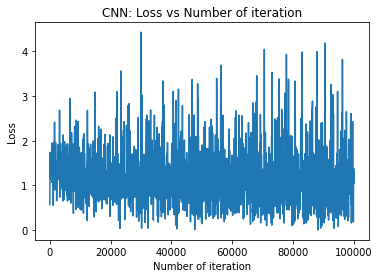

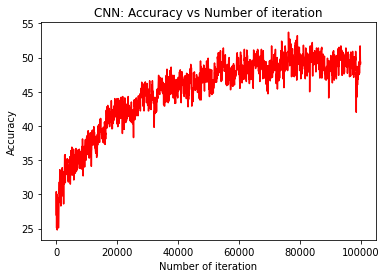

In [ ]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

#### Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev to construct an CNN (rotation)

Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.353333


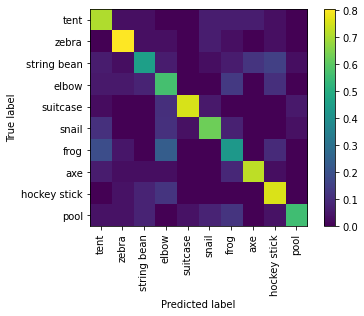

Number of classes = 50
Performing linear SVM!
Selected classifier with best dev error 0.796667


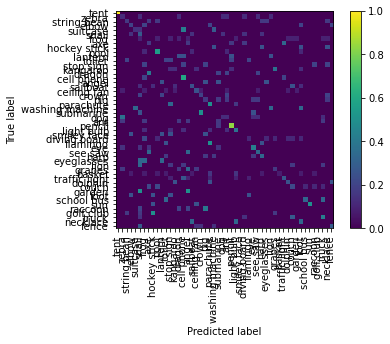

In [ ]:
dev_err_cnn_rot_self = {}
test_results["rotation_cnn"] = {}
for c in [10, 50]:
    print("Number of classes = {}".format(c))
    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, _, _ = labeled_test_data[c]

    rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_x_pixel).cpu()
    dev_rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_x_pixel_dev).cpu()
    test_rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_test_pixel).cpu()


    cnn_rot_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        rot_pixel_features, labeled_y, 
        dev_rot_pixel_features, labeled_y_dev, 
        test_rot_pixel_features
    )    
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()

    dev_err_cnn_rot_self[c] = cnn_rot_self_best_error_dev
    test_results["rotation_cnn"][c] = test_pred

#### Plot

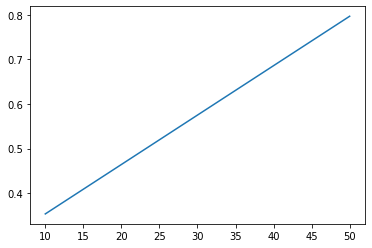

In [ ]:
x, y = zip(*sorted(dev_err_cnn_rot_self.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_cnn_rot_self

### Compression CNN

#### Train

In [ ]:
# SGD Optimizer
learning_rate = 0.001
comp_cnn = CNNModel(3)
comp_cnn = comp_cnn.to(device)
optimizer = torch.optim.SGD(comp_cnn.parameters(), lr=learning_rate)

In [ ]:
#Definition of hyperparameters
#n_iters = 300000 #changed from 180000 with new classes
#num_epochs = n_iters / (len(rot_pixel_train) / batch_size)
#num_epochs = int(num_epochs)

n_iters = 5000
num_epochs = 10

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    indices = np.random.choice(len(train_y_comp_pixel_deform), n_iters)
    subset_x = train_comp_pixel_deform[indices]
    subset_y = train_y_comp_pixel_deform[indices]
    train_data = torch.utils.data.TensorDataset(subset_x, subset_y)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=False)
    
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(1,1,28,28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs, _ = comp_cnn(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
            
        if count % 50 == 0:
            # Calculate Accuracy and append loss       
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in comp_dev_loader:
                
                test = Variable(images.view(1,1,28,28))
                # Forward propagation
                outputs, _ = comp_cnn(test)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 1.2398931980133057  Accuracy: 89.30000305175781 %
Iteration: 1000  Loss: 0.007129347883164883  Accuracy: 85.9000015258789 %
Iteration: 1500  Loss: 1.1172163486480713  Accuracy: 92.60000610351562 %
Iteration: 2000  Loss: 0.014099509455263615  Accuracy: 81.10000610351562 %
Iteration: 2500  Loss: 0.0760335773229599  Accuracy: 92.4000015258789 %
Iteration: 3000  Loss: 0.04596666619181633  Accuracy: 95.50000762939453 %
Iteration: 3500  Loss: 0.0022264947183430195  Accuracy: 94.60000610351562 %
Iteration: 4000  Loss: 0.024249497801065445  Accuracy: 96.10000610351562 %
Iteration: 4500  Loss: 1.6689286894688848e-06  Accuracy: 95.30000305175781 %
Iteration: 5000  Loss: 0.023475216701626778  Accuracy: 96.80000305175781 %
Iteration: 5500  Loss: 0.002878453116863966  Accuracy: 98.20000457763672 %
Iteration: 6000  Loss: 8.344646857949556e-07  Accuracy: 97.20000457763672 %
Iteration: 6500  Loss: 1.6093124941107817e-05  Accuracy: 98.30000305175781 %
Iteration: 7000  Loss: 1.2279

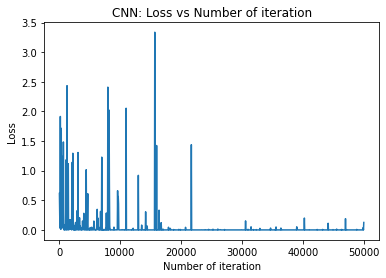

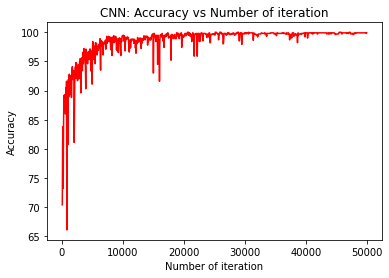

In [ ]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

#### Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev to construct an CNN (compression)

Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.456667


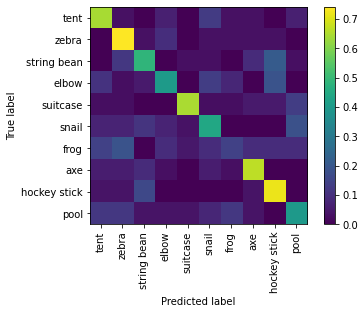

Number of classes = 50
Performing linear SVM!
Selected classifier with best dev error 0.783333


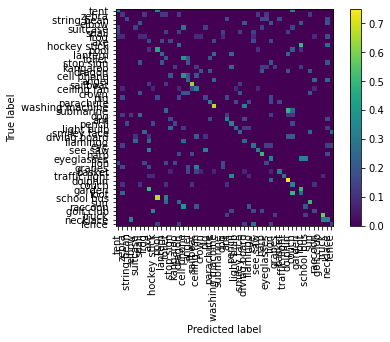

In [ ]:
dev_err_cnn_comp_self = {}
test_results["compression_cnn"] = {}
for c in [10,50]:
    print("Number of classes = {}".format(c))
    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, _, _ = labeled_test_data[c]

    comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_x_pixel).cpu()
    dev_comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_x_pixel_dev).cpu()
    test_comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_test_pixel).cpu()

    cnn_comp_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        comp_pixel_features, labeled_y, 
        dev_comp_pixel_features, labeled_y_dev, 
        test_comp_pixel_features
    )    
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    
    dev_err_cnn_comp_self[c] = cnn_comp_self_best_error_dev
    test_results["compression_cnn"][c] = test_pred

#### Plot

In [ ]:
x, y = zip(*sorted(dev_err_cnn_comp_self.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_cnn_comp_self

### Combining CNN rotation and compression

Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.336667


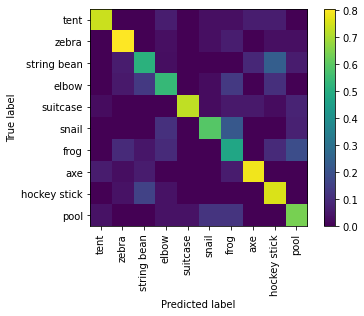

Number of classes = 50
Performing linear SVM!
Selected classifier with best dev error 0.743333


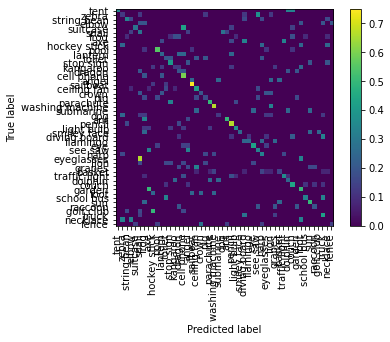

In [ ]:
dev_err_cnn_comp_self = {}
test_results["rotation_compression_cnn"] = {}
for c in [10, 50]:
    print("Number of classes = {}".format(c))
    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, _, _ = labeled_test_data[c]

    rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_x_pixel).cpu()
    dev_rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_x_pixel_dev).cpu()
    test_rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_test_pixel).cpu()

    comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_x_pixel).cpu()
    dev_comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_x_pixel_dev).cpu()
    test_comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_test_pixel).cpu()

    cnn_pixel_features = np.concatenate((rot_pixel_features, comp_pixel_features), axis=1)
    dev_cnn_pixel_features = np.concatenate((dev_rot_pixel_features, dev_comp_pixel_features), axis=1)
    test_cnn_pixel_features = np.concatenate((test_rot_pixel_features, test_comp_pixel_features), axis=1)

    cnn_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        cnn_pixel_features, labeled_y, 
        dev_cnn_pixel_features, labeled_y_dev, 
        test_cnn_pixel_features
    )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    
    dev_err_cnn_comp_self[c] = cnn_comp_self_best_error_dev
    test_results["rotation_compression_cnn"][c] = test_pred


## Combining RNN and CNN

Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.356667


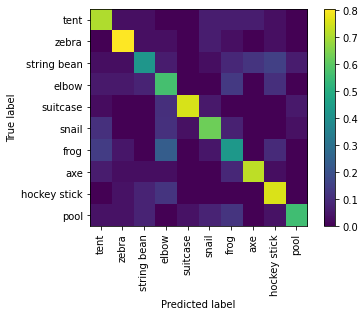

Number of classes = 50
Performing linear SVM!
Selected classifier with best dev error 0.790000


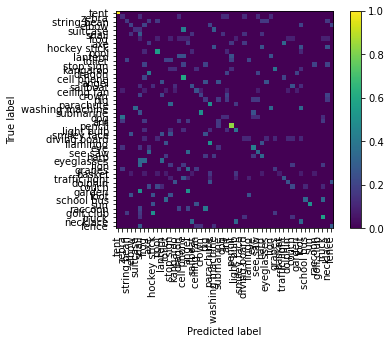

In [ ]:
# RNN compressionion and CNN rotation
test_results["rotation_rnn_cnn"] = {}
for c in [10, 50]:
    print("Number of classes = {}".format(c))
    labeled_x_pixel, labeled_x_ink, labeled_y, labeled_x_pixel_dev, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, labeled_test_ink, _ = labeled_test_data[c]

    rot_ink_features = extract_feature_rnn(rot_rnn, labeled_x_ink).cpu()
    dev_rot_ink_features = extract_feature_rnn(rot_rnn, labeled_x_ink_dev).cpu()
    test_rot_ink_features = extract_feature_rnn(rot_rnn, labeled_test_ink).cpu()

    rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_x_pixel).cpu()
    dev_rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_x_pixel_dev).cpu()
    test_rot_pixel_features = extract_feature_cnn(rot_cnn, labeled_test_pixel).cpu()
    
    rot_features = np.concatenate((rot_ink_features, rot_pixel_features), axis=1)
    dev_rot_features = np.concatenate((dev_rot_ink_features, dev_rot_pixel_features), axis=1)
    test_rot_features = np.concatenate((test_rot_ink_features, test_rot_pixel_features), axis=1)

    rot_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        rot_features, labeled_y, 
        dev_rot_features, labeled_y_dev, 
        test_rot_features
    )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    
    test_results["rotation_rnn_cnn"][c] = test_pred


Number of classes = 10
Performing linear SVM!
Selected classifier with best dev error 0.436667


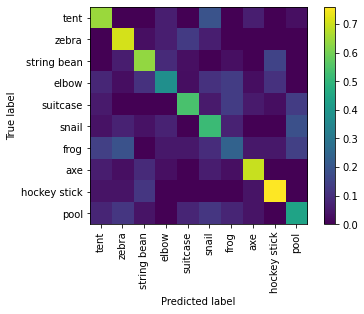

Number of classes = 50
Performing linear SVM!
Selected classifier with best dev error 0.780000


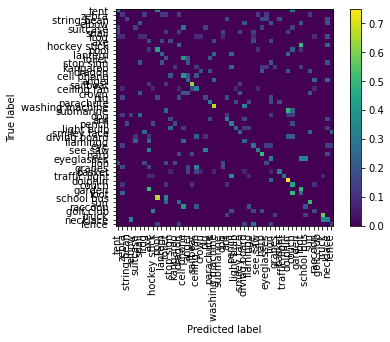

In [ ]:
# RNN compation and CNN compation
test_results["compression_rnn_cnn"] = {}
for c in [10, 50]:
    print("Number of classes = {}".format(c))
    labeled_x_pixel, labeled_x_ink, labeled_y, labeled_x_pixel_dev, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    labeled_test_pixel, labeled_test_ink, _ = labeled_test_data[c]

    comp_ink_features = extract_feature_rnn(comp_rnn, labeled_x_ink).cpu()
    dev_comp_ink_features = extract_feature_rnn(comp_rnn, labeled_x_ink_dev).cpu()
    test_comp_ink_features = extract_feature_rnn(comp_rnn, labeled_test_ink).cpu()

    comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_x_pixel).cpu()
    dev_comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_x_pixel_dev).cpu()
    test_comp_pixel_features = extract_feature_cnn(comp_cnn, labeled_test_pixel).cpu()
    
    comp_features = np.concatenate((comp_ink_features, comp_pixel_features), axis=1)
    dev_comp_features = np.concatenate((dev_comp_ink_features, dev_comp_pixel_features), axis=1)
    test_comp_features = np.concatenate((test_comp_ink_features, test_comp_pixel_features), axis=1)

    comp_self_best_error_dev, pred_dev_y, test_pred = linear_svm(
        comp_features, labeled_y, 
        dev_comp_features, labeled_y_dev, 
        test_comp_features
    )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    
    test_results["compression_rnn_cnn"][c] = test_pred


# VAE RNN
Follow: https://github.com/magenta/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb

#### Setup

In [ ]:
!pip install -qU svgwrite
!pip install -q magenta
!pip install numpy==1.16.1

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.4MB 5.9MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 358kB 15.4MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 1.6MB 16.7MB/s 
     |████████████████████████████████| 2.3MB 35.7MB/s 
     |████████████████████████████████| 1.5MB 36.4MB/s 
     |████████████████████████████████| 204kB 43.9MB/s 
     |████████████████████████████████| 3.6MB 45.7MB/s 
     |████████████████████████████████| 215kB 40.6MB/s 
     |████████████████████████████████| 5.6MB 39.2MB/s 
     |████████████████████████████████| 256kB 39.1MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 5.6MB 37.3MB/s 
     |████████████████████████████████| 194kB 44.4MB/s 
     |████████████████████████████████| 368kB 41.5MB/s 
     |████████████████████████████████| 655kB 37.7MB/s 
 

In [ ]:
# import the required libraries
import codecs
import collections
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
#import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)
import svgwrite # conda install -c omnia svgwrite=1.1.6

# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [ ]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = '/tmp/sketch_rnn/models'
model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'
#PRETRAINED_MODELS_URL

In [ ]:
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
INFO:tensorflow:Download complete.
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


In [ ]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)
np.load = np_load_old

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep//aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [ ]:
# construct the sketch-rnn model here:
reset_graph()
tf.compat.v1.disable_eager_execution()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode =

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


In [ ]:
def encode(input_strokes, draw_mode=False):
  if input_strokes.shape[0] > 250:
    input_strokes = input_strokes[:250]
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  if draw_mode:
    visualize_ink_image(to_normal_strokes(np.array(strokes)))
    #draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [ ]:
def decode(z_input=None, draw_mode=False, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    visualize_ink_image(strokes)
    #draw_strokes(strokes, factor)
  return strokes

In [ ]:
#stroke = test_set.random_sample()
#x_ink_data[0][12100]
#z = encode(stroke)
#z.shape
#_ = decode(z, temperature=0.9) # convert z back to drawing at temperature of 0.8

#### Train & Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev to construct an RNN VAE

In [ ]:
#train_x, dev_x, test_x = x_ink_data[0], x_ink_data[1], x_ink_data[2]
#train_y, dev_y, test_y = y_data[0], y_data[1], y_data[2]
#train_pixel_x, dev_pixel_x, test_pixel_x = x_pixel_data[0], x_pixel_data[1], x_pixel_data[2]

Number of classes = 10
Time taken to encode 94.18916249275208
Performing linear SVM!
Selected classifier with best dev error 0.746667


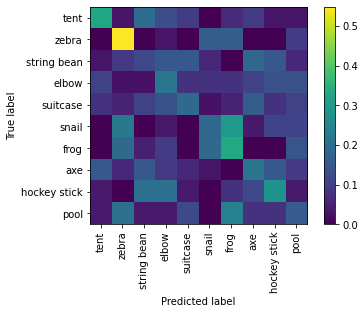

Number of classes = 50
Time taken to encode 107.7870032787323
Performing linear SVM!
Selected classifier with best dev error 0.956667


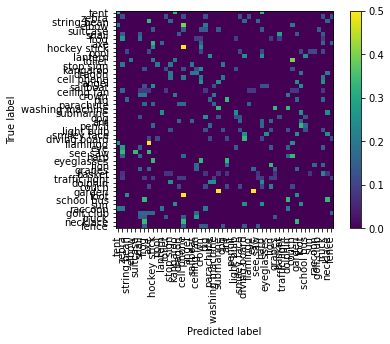

In [ ]:
dev_err_rnn_vae = {}
test_results["vae_rnn"] = {}
for c in [10, 50]:
    print("Number of classes = {}".format(c))

    _, labeled_x_ink, labeled_y, _, labeled_x_ink_dev, labeled_y_dev = labeled_data[c]
    _, labeled_test_ink, _ = labeled_test_data[c]
    
    t0 = time.time()
    f = lambda x: encode(x)
    train_z = np.array([f(xi) for xi in labeled_x_ink])
    dev_z = np.array([f(xi) for xi in labeled_x_ink_dev])
    test_z = np.array([f(xi) for xi in labeled_test_ink])
    t1 = time.time()
    print("Time taken to encode", t1-t0)

    rnn_vae_best_error_dev, pred_dev_y, test_pred = linear_svm(
            train_z, labeled_y, 
            dev_z, labeled_y_dev, 
            test_z
        )
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    dev_err_rnn_vae[c] = rnn_vae_best_error_dev
    test_results["vae_rnn"][c] = test_pred

#### Plot

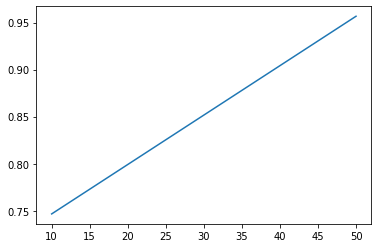

In [ ]:
x, y = zip(*sorted(dev_err_rnn_vae.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_rnn_vae

{10: 0.7466666666666667, 50: 0.9566666666666667}

In [ ]:
#org_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#org_clf.fit(train_pixel_x[:100], train_y[:100])
#org_clf.score(test_pixel_x[:1000], test_y[:1000])
#vae_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#vae_clf.fit(train_z, train_y[:100])
#vae_clf.score(test_z, test_y[:1000])

# VAE CNN

Modify VAE codes from HW2 to allow for CNN VAE

#### Setup

In [ ]:
class VAE(object):
    """Variational AutoEncoder (VAE)

    Parameters
    ----------
    n_inputs: int, feature size of input data
    n_components: int, feature size of output
    lr: float, learning rate (default: 0.001)
    batch_size: int, batch size (default: 128)
    cuda: bool, whether to use GPU if available (default: True)
    path: string, path to save trained model (default: "vae.pth")
    kkl: float, float, weight on loss term -KL(q(z|x)||p(z)) (default: 1.0)
    kv: float, weight on variance term inside -KL(q(z|x)||p(z)) (default: 1.0)
    """
    def __init__(self, n_inputs, n_components, lr=1.0e-3, batch_size=64, cuda=True, path="vae.pth", kkl=1.0, kv=1.0):
        self.model = VNet(n_inputs, n_components)
        self.device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.batch_size = batch_size
        self.lr = lr
        self.path = path
        self.kkl = kkl
        self.kv = kv
        self.initialize()

    def fit(self, Xr, Xd, epochs):
        """Fit VAE from data Xr
        Parameters
        ----------
        :in:
        Xr: 2d array of shape (n_data, n_dim). Training data
        Xd: 2d array of shape (n_data, n_dim). Dev data, used for early stopping
        epochs: int, number of training epochs
        """
        train_loader = tud.DataLoader(MNIST(Xr, transform=ToTensor()),
            batch_size=self.batch_size, shuffle=True)
        dev_loader = tud.DataLoader(
            MNIST(Xd, transform=ToTensor()),
            batch_size=self.batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        best_dev_loss = np.inf
        for epoch in range(1, epochs + 1):
            train_loss = self._train(train_loader, optimizer)
            dev_loss, _ = self._evaluate(dev_loader)
            if dev_loss < best_dev_loss:
                torch.save(self.model, self.path)
                best_dev_loss = dev_loss
            print('Epoch: %d, train loss: %.4f, dev loss: %.4f' % (
                epoch, train_loss, dev_loss))
        return

    def transform(self, X):
        """Transform X
        Parameters
        ----------
        :in:
        X: 2d array of shape (n_data, n_dim)
        :out:
        Z: 2d array of shape (n_data, n_components)
        """
        try:
            self.model = torch.load(self.path)
        except Exception as err:
            print("Error loading '%s'\n[ERROR]: %s\nUsing initial model!" % (self.path, err))
        test_loader = tud.DataLoader(MNIST(X, transform=ToTensor()), batch_size=self.batch_size, shuffle=False)
        _, Z = self._evaluate(test_loader)
        return Z

    def _train(self, train_loader, optimizer):
        self.model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(self.device)
            data = data.reshape(-1, 1, 28, 28)
            optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self._loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        return train_loss/(batch_idx+1)

    def _evaluate(self, loader):
        self.model.eval()
        loss = 0
        fs = []
        with torch.no_grad():
            for batch_idx, data in enumerate(loader):
                data = data.to(self.device)
                data = data.reshape(-1, 1, 28, 28)
                recon_batch, mu, logvar = self.model(data)
                loss += self._loss_function(recon_batch, data, mu, logvar).item()
                fs.append(mu)
        fs = torch.cat(fs).cpu().numpy()
        return loss/(batch_idx+1), fs

    def _loss_function(self, recon_x, x, mu, logvar):
        """VAE Loss
        Parameters
        ----------
        :in:
        recon_x: 2d tensor of shape (batch_size, n_dim), reconstructed input
        x: 2d tensor of shape (batch_size, n_dim), input data
        mu: 2d tensor of shape (batch_size, n_components), latent mean
        logvar: 2d tensor of shape (batch_size, n_components), latent log-variance
        :out:
        l: 1d tensor, VAE loss
        """
        n, d = mu.shape
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')/n
        KLD = -0.5*(d + self.kv*(logvar-logvar.exp()).sum()/n - mu.pow(2).sum()/n)
        l = BCE + self.kkl*KLD
        return l

    def initialize(self):
        """
        Model Initialization
        """
        def _init_weights(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

        self.model.apply(_init_weights)
        return

def vae_emb(train_subset, dev_subset, train_data, dev_data, test_data, 
            n_components, lr=0.001, batch_size=128,
            epochs=15, kkl=1.0, kv=1.0, path='VAE.pt'
        ):
    """
    Train and extract feature with VAE
    ------
    Input
        train_subset, dev_subset: 2d array of shape (n_data, n_dim), VAE 
            training and development data
        train_data, dev_data, test_data: 2d array of shape (n_data, n_dim), 
            training/dev/test set of the dataset, where trained VAE will be 
            used to extract features
        n_components: int, feature dimension
        lr: float, learning rate (default: 0.001)
        batch_size: int, batch size to train VAE (default: 128)
        epochs: int, training epochs (default: 20)
        kkl: float, weight (lambda_KL) on -KL(q(z|x)||p(z)) (default: 1.0)
        kv: float, weight (lambda_var) on variance term inside -KL(q(z|x)||p(z)) 
            (default: 1.0)
        path: string, path to save trained model (default: "VAE.pt")
    
    Output
        train_features, dev_features, test_features: 2d array of shape 
            (n_data, n_dim), extracted features of the training/dev/test set
    """
    print("Using VAE")
    model = VAE(
        n_inputs=train_subset.shape[1], 
        n_components=n_components, 
        lr=lr, 
        batch_size=batch_size, 
        kkl=kkl, 
        kv=kv, 
        path=path
    )
    model.fit(train_subset, Xd=dev_subset, epochs=epochs)
    train_features = model.transform(train_data)
    dev_features = model.transform(dev_data)
    test_features = model.transform(test_data)
    return train_features, dev_features, test_features

In [ ]:
"""VAE implementation based on Pytorch"""

from __future__ import print_function
from __future__ import division
import torch
import torch.utils.data as tud
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from dataset import read_mnist

class MNIST(tud.Dataset):
    def __init__(self, X, transform=None):
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        return x

class ToTensor(object):
    def __call__(self, sample):
        m = torch.from_numpy(sample).type(torch.float)
        return m

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=32):
        return input.view(input.size(0), size, 6, 6)

class VNet(nn.Module):
    """
    VAE Network Architecture

    Parameters
    ----------
    dx: int, input dimension
    dh: int, latent dimension
    """
    def __init__(self, dx, dh):
        super(VNet, self).__init__()
        self.enc = nn.Sequential(
            # Convolution 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            # Max pool 1
            #nn.MaxPool2d(kernel_size=2),
        
            # Convolution 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            # Max pool 2
            #nn.MaxPool2d(kernel_size=2),
            Flatten()
        )

        self.fc1 = nn.Linear(32 * 6 * 6, dh)
        self.fc2 = nn.Linear(32 * 6 * 6, dh)
        self.fc3 = nn.Linear(dh, 32 * 6 * 6)

        self.dec = nn.Sequential(
                    UnFlatten(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=1),
                    nn.Sigmoid()
                )
        
    def encode(self, x):
        #print("start encode")
        #print("before encode", x.shape)
        h = self.enc(x)
        #print("after encode", h.shape)
        #print(self.fc1(h).shape, self.fc2(h).shape)
        return self.fc1(h), self.fc2(h)

    def reparameterize(self, mu, logvar):
        #print("start reparameterize")
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        #print("after reparameterize", z.shape)
        return z

    def decode(self, x):
        #print("start decode")
        #print("before decode", x.shape)
        z = self.fc3(x)
        #print("after decode - dense", z.shape)
        z = self.dec(z)
        #print("after decode", z.shape)
        return z

    def forward(self, x):
        #print("start forward")
        #print("before forward", x.shape)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        #print("after forward - encode", z.shape)
        z = self.decode(z)
        #print("after forward - decode", z.shape)
        return z, mu, logvar

#### Train & Evaluate
1,000 labeled samples from devtest (for classification: split into train & dev), using all unlabeled data from train & dev to construct an CNN VAE

In [ ]:
train_x_pixel_norm = train_x_pixel/np.linalg.norm(train_x_pixel)
dev_x_pixel_norm = dev_x_pixel/np.linalg.norm(dev_x_pixel)
devtest_x_pixel_norm = devtest_x_pixel/np.linalg.norm(devtest_x_pixel)
test_x_pixel_norm = test_x_pixel/np.linalg.norm(test_x_pixel)

No of classes 10
['pool', 'hockey stick', 'frog', 'elbow', 'zebra', 'string bean', 'axe', 'tent', 'suitcase', 'snail']
Using VAE
Epoch: 1, train loss: 60.6616, dev loss: 36.9608
Epoch: 2, train loss: 32.8619, dev loss: 28.7480
Epoch: 3, train loss: 23.7983, dev loss: 20.2708
Epoch: 4, train loss: 17.6733, dev loss: 15.5304
Epoch: 5, train loss: 13.4988, dev loss: 11.8717
Epoch: 6, train loss: 10.3107, dev loss: 9.1065
Epoch: 7, train loss: 7.9159, dev loss: 7.0411
Epoch: 8, train loss: 6.1301, dev loss: 5.5018
Epoch: 9, train loss: 4.7952, dev loss: 4.3478
Epoch: 10, train loss: 3.7911, dev loss: 3.4769
Epoch: 11, train loss: 3.0309, dev loss: 2.8159
Epoch: 12, train loss: 2.4526, dev loss: 2.3120
Epoch: 13, train loss: 2.0105, dev loss: 1.9255
Epoch: 14, train loss: 1.6707, dev loss: 1.6283
Epoch: 15, train loss: 1.4086, dev loss: 1.3981
Performing linear SVM!
Selected classifier with best dev error 0.520000


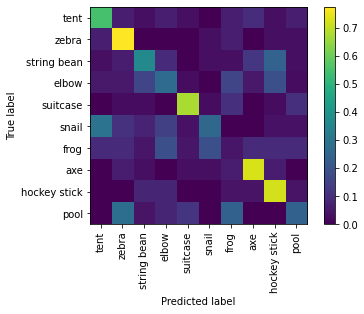

No of classes 50
['pool', 'hockey stick', 'frog', 'elbow', 'zebra', 'string bean', 'axe', 'tent', 'suitcase', 'snail']
Using VAE
Epoch: 1, train loss: 69.4071, dev loss: 41.2665
Epoch: 2, train loss: 36.7248, dev loss: 32.6620
Epoch: 3, train loss: 27.8682, dev loss: 23.5420
Epoch: 4, train loss: 20.2867, dev loss: 17.7782
Epoch: 5, train loss: 15.4773, dev loss: 13.5995
Epoch: 6, train loss: 11.8227, dev loss: 10.4199
Epoch: 7, train loss: 9.0678, dev loss: 8.0429
Epoch: 8, train loss: 7.0069, dev loss: 6.2638
Epoch: 9, train loss: 5.4621, dev loss: 4.9281
Epoch: 10, train loss: 4.2993, dev loss: 3.9199
Epoch: 11, train loss: 3.4197, dev loss: 3.1557
Epoch: 12, train loss: 2.7510, dev loss: 2.5725
Epoch: 13, train loss: 2.2400, dev loss: 2.1263
Epoch: 14, train loss: 1.8478, dev loss: 1.7835
Epoch: 15, train loss: 1.5457, dev loss: 1.5184
Performing linear SVM!


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Selected classifier with best dev error 0.900000


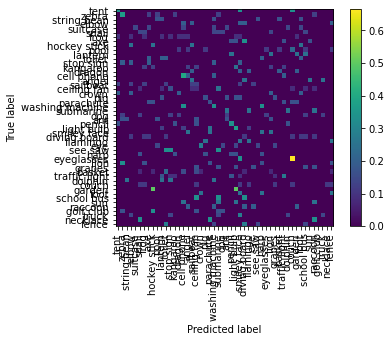

In [ ]:
dev_err_cnn_vae = {}
test_results["vae_cnn"] = {}
for c in [10,50]:
    print("No of classes", c)
    #cls_idx = np.random.permutation(c)
    #cls = [classes[i] for i in cls_idx]
    print(cls)
    cls_size = 1000

    labeled_x_pixel, _, labeled_y, labeled_x_pixel_dev, _, labeled_y_dev = labeled_data[c]
    # labeled_x_pixel_norm = labeled_x_pixel/np.linalg.norm(labeled_x_pixel)
    # labeled_x_pixel_dev_norm = labeled_x_pixel_dev/np.linalg.norm(labeled_x_pixel_dev)
    labeled_test_pixel, _, _ = labeled_test_data[c]
    # labeled_test_pixel_norm = labeled_test_pixel/np.linalg.norm(labeled_test_pixel)

    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_pixel_norm,
        dev_x_pixel_norm,
        labeled_x_pixel,
        labeled_x_pixel_dev,
        labeled_test_pixel, n_components=64
    )

    cnn_vae_best_error_dev, pred_dev_y, test_pred = linear_svm(
            z_vae_train, labeled_y, 
            z_vae_dev, labeled_y_dev, 
            z_vae_test
        )    
      
    
    m = confusion_matrix(labeled_y_dev, pred_dev_y, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()
    dev_err_cnn_vae[c] = cnn_vae_best_error_dev
    test_results["vae_cnn"][c] = test_pred

In [ ]:
#vae_clf_2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#vae_clf_2.fit(z_vae_train[:100], train_y[:100])
#vae_clf_2.score(z_vae_test[:1000], test_y[:1000])
#org_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#org_clf.fit(train_pixel_x[:100], train_y[:100])
#org_clf.score(test_pixel_x[:1000], test_y[:1000]) has  

#### Plot

In [ ]:
x, y = zip(*sorted(dev_err_cnn_vae.items()))
plt.plot(x, y)
plt.show()

In [ ]:
dev_err_cnn_vae

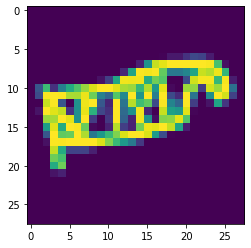

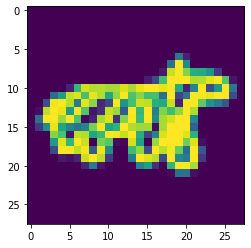

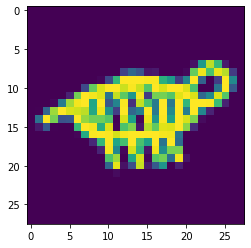

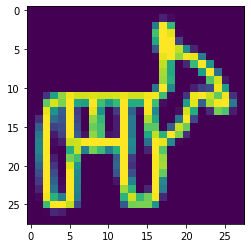

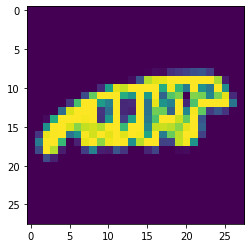

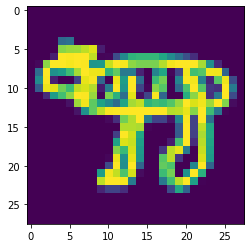

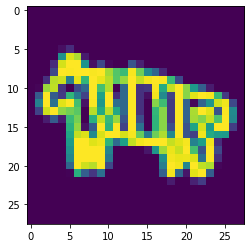

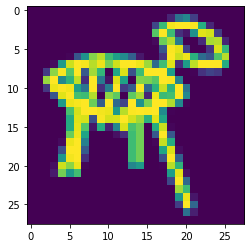

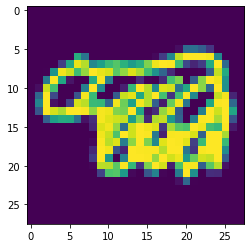

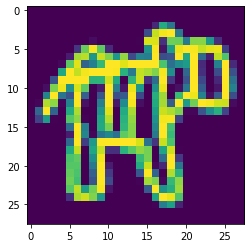

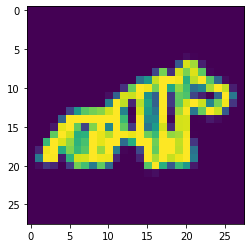

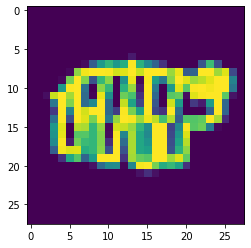

KeyboardInterrupt: ignored

In [ ]:
pred_class10 = test_results["vae_cnn"][10]
pixel_test_10, ink_test_10, labeled_test_10 = labeled_test_data[10]

for i in range(len(pred_class10)):
    if pred_class10[i] == 1 and labeled_test_10[i] == 1: 
      #print(pred_class10[i], labeled_test_10[i])
      plt.imshow(pixel_test_10[i].reshape(28,28))
      plt.show()

# Evaluate on Test Set

In [ ]:
def evaluate(dev_err, preds, actuals):
  test_err = np.mean(preds == actuals)
  # print(f'Best dev error = {dev_err:.6f}')
  print(f'Test accuracy = {test_err:.6f}')

baseline
Test accuracy = 0.403000
Test accuracy = 0.171000


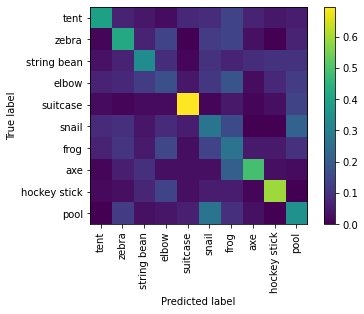

pca_labeled_only
Test accuracy = 0.571000
Test accuracy = 0.221000


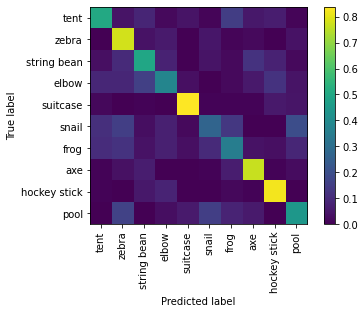

pca_with_unlabeled
Test accuracy = 0.553000
Test accuracy = 0.205000


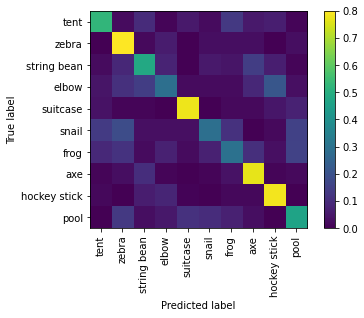

rotation_rnn
Test accuracy = 0.172000
Test accuracy = 0.044000


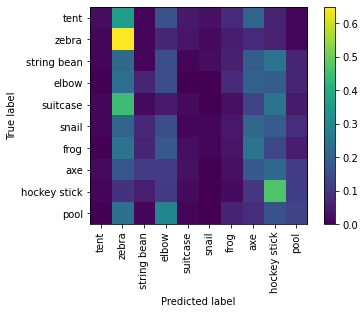

compression_rnn
Test accuracy = 0.163000
Test accuracy = 0.035000


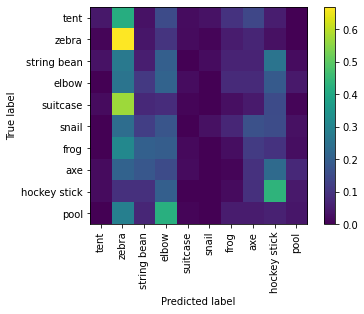

rotation_cnn
Test accuracy = 0.645000
Test accuracy = 0.265000


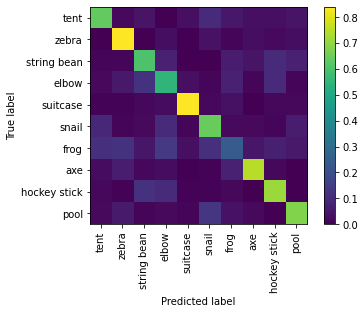

compression_cnn
Test accuracy = 0.560000
Test accuracy = 0.192000


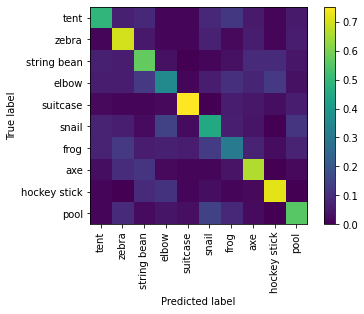

rotation_compression_cnn
Test accuracy = 0.666000
Test accuracy = 0.283000


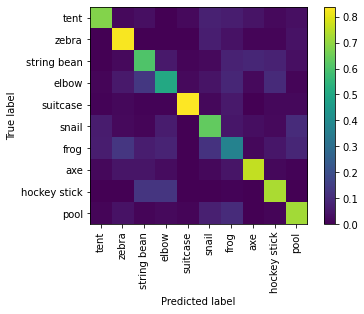

vae_rnn
Test accuracy = 0.269000
Test accuracy = 0.039000


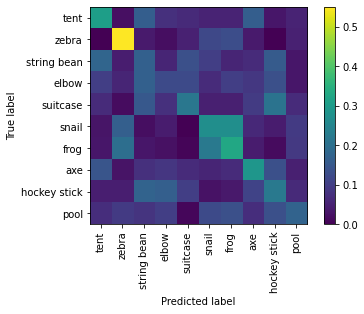

vae_cnn
Test accuracy = 0.438000
Test accuracy = 0.102000


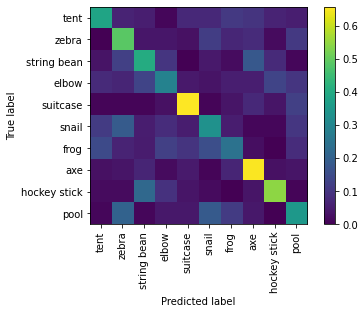

rotation_compression_rnn
Test accuracy = 0.172000
Test accuracy = 0.046000


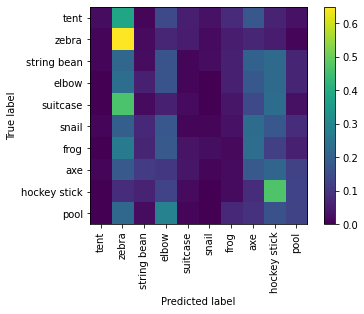

rotation_rnn_cnn
Test accuracy = 0.647000
Test accuracy = 0.262000


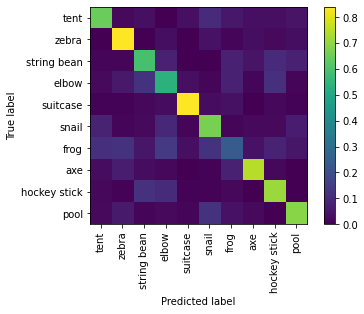

compression_rnn_cnn
Test accuracy = 0.556000
Test accuracy = 0.193000


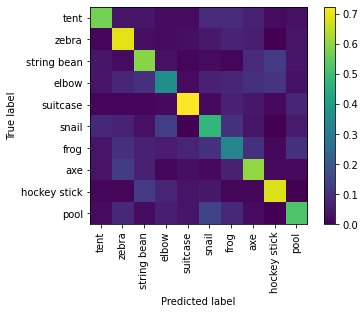

In [ ]:
# All confusion matrices
pixel_test_10, ink_test_10, labeled_test_10 = labeled_test_data[10]
pixel_test_50, ink_test_50, labeled_test_50 = labeled_test_data[50]
for key, value in test_results.items(): 
    print(key)
    pred_class10 = value[10]
    pred_class50 = value[50]
    error10 = evaluate(0, pred_class10, labeled_test_10)
    error50 = evaluate(0, pred_class50, labeled_test_50)
    m = confusion_matrix(labeled_test_10, pred_class10, normalize="true")
    p = ConfusionMatrixDisplay(m, classes[:c])
    p.plot(include_values=False, xticks_rotation="vertical")
    plt.show()

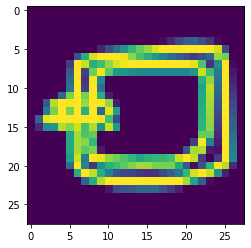

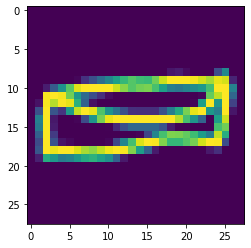

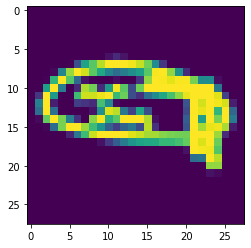

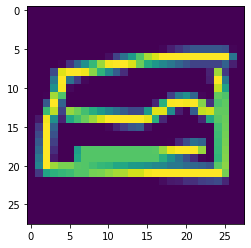

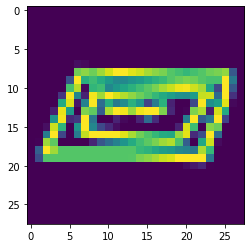

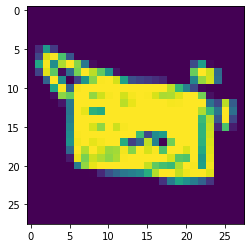

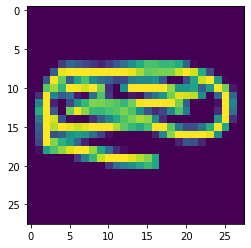

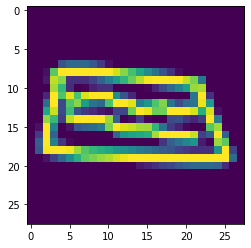

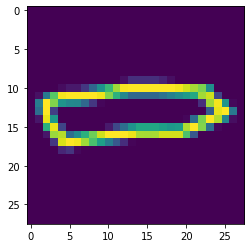

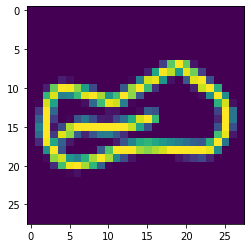

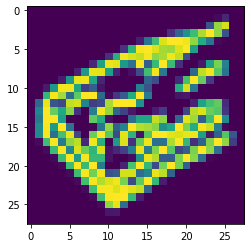

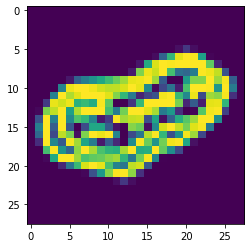

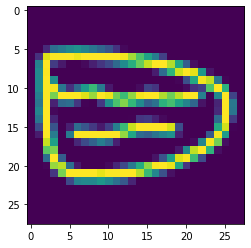

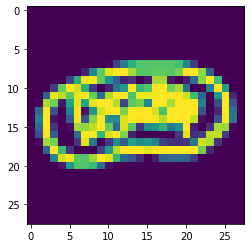

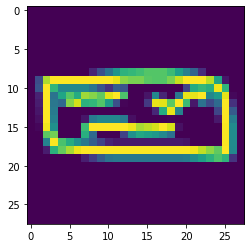

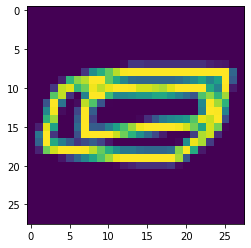

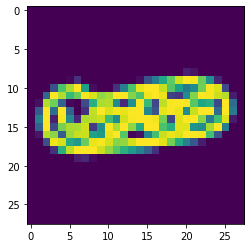

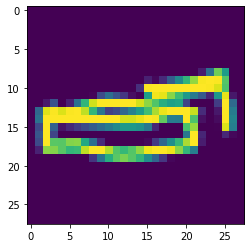

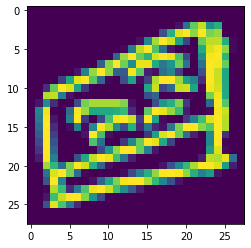

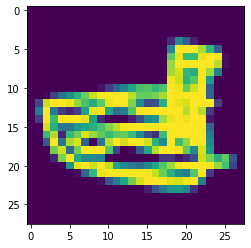

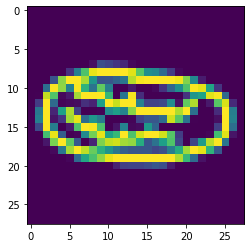

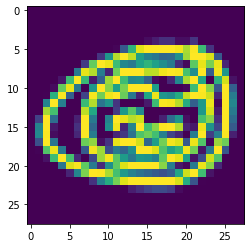

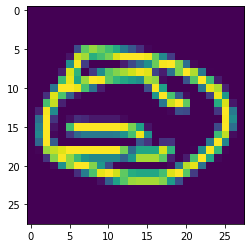

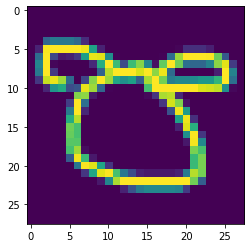

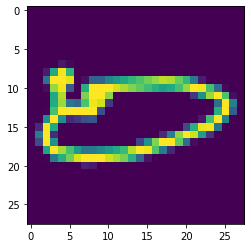

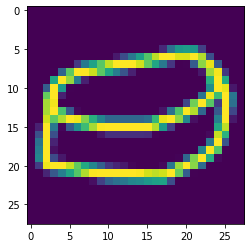

In [ ]:
# baseline confusions
# Pools confused with snails
pred_class10 = test_results["baseline"][10]
for i in range(len(pred_class10)):
    if pred_class10[i] == 5 and labeled_test_10[i] == 9: 
        plt.imshow(pixel_test_10[i].reshape(28,28))
        plt.show()

In [ ]:
labeled_test_10.dtype

dtype('int64')

In [ ]:
np.savetxt('drive/MyDrive/unsupervised_final_project/true_labels.txt', labeled_test_10, fmt ='%.0f\n')

In [ ]:

for key, value in test_results.items(): 
    print(key)
    pred_class10 = value[10]
    pred_class50 = value[50]
    np.savetxt('drive/MyDrive/unsupervised_final_project/{}_10_classes.txt'.format(key), pred_class10, fmt ='%.0f\n')
    np.savetxt('drive/MyDrive/unsupervised_final_project/{}_50_classes.txt'.format(key), pred_class50, fmt ='%.0f\n')
    

baseline
pca_labeled_only
pca_with_unlabeled
rotation_rnn
compression_rnn
rotation_cnn
compression_cnn
rotation_compression_cnn
vae_rnn
vae_cnn
rotation_compression_rnn
rotation_rnn_cnn
compression_rnn_cnn
